# Code 9: End to End Bayesian Workflows

In [1]:
import pandas as pd
import arviz as az

import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from scipy import stats, optimize

np.random.seed(seed=233423)
sampling_random_seed = 0

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300 

### Load flight data

In [4]:
df = pd.read_csv("../data/948363589_T_ONTIME_MARKETING.zip", low_memory=False)

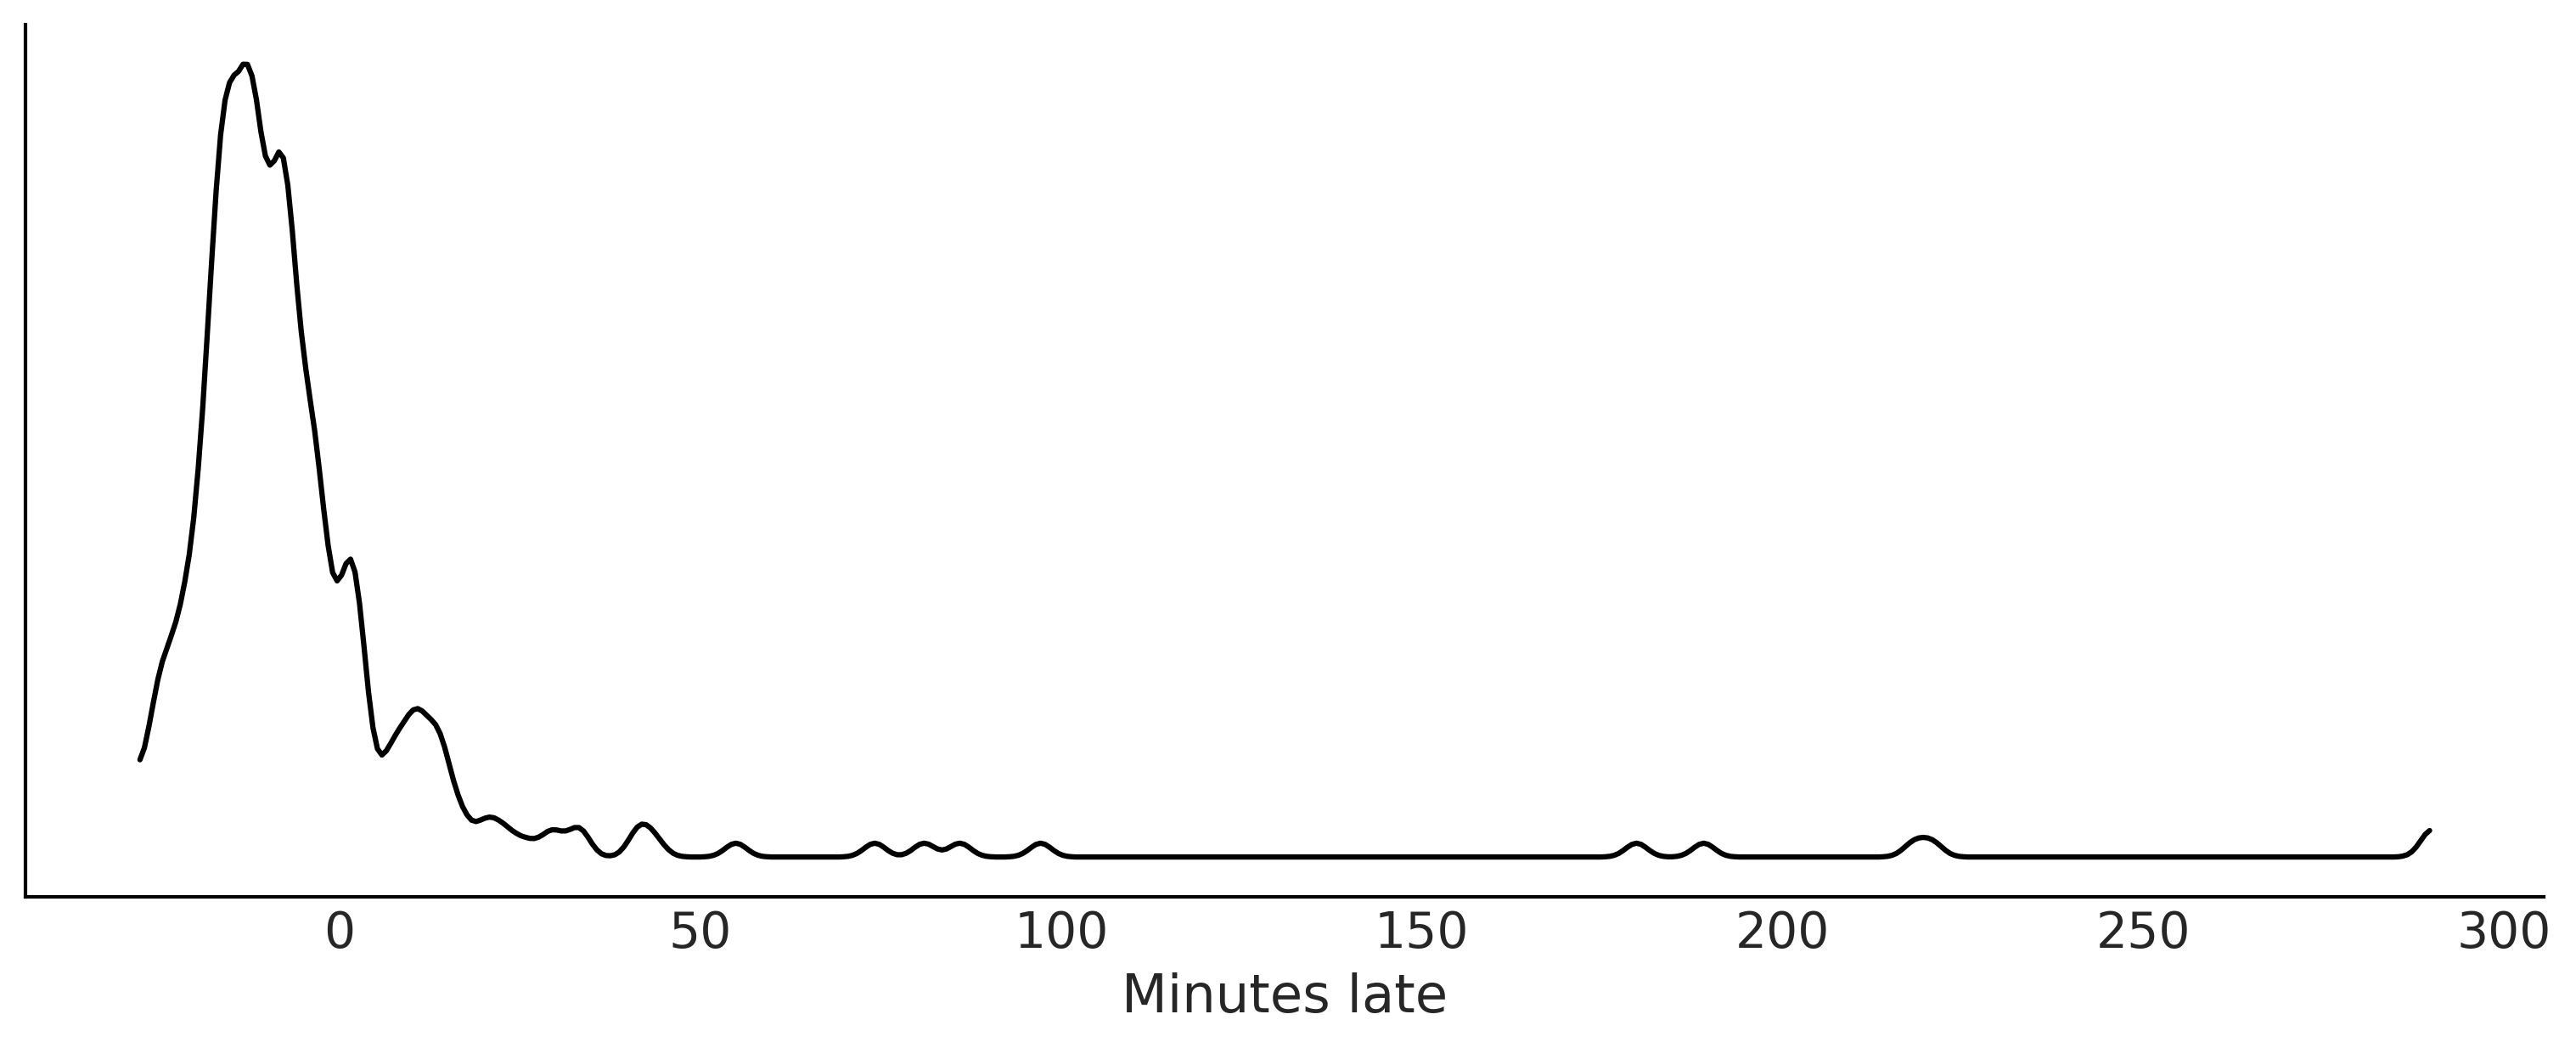

In [5]:
fig, ax = plt.subplots(figsize=(10,4))
msn_arrivals = df[(df["DEST"] == 'MSN') & df["ORIGIN"]
                  .isin(["MSP", "DTW"])]["ARR_DELAY"]

az.plot_kde(msn_arrivals.values, ax=ax)
ax.set_yticks([])
ax.set_xlabel("Minutes late")
plt.savefig('img/chp09/arrivaldistributions.png')

In [6]:
msn_arrivals.notnull().value_counts()

True    336
Name: ARR_DELAY, dtype: int64

In [7]:
try:
    # This is the real code, just try except block to allow for the whole notebook tor execute
    with pm.Model() as normal_model:
        normal_mu = ...
        normal_sd = ...

        normal_delay = pm.SkewNormal("delays", mu=normal_mu,
                                     sd=normal_sd, observed=msn_arrivals)

    with pm.Model() as skew_normal_model:
        skew_normal_alpha = ...
        skew_normal_mu = ...
        skew_normal_sd = ...

        skew_normal_delays = pm.SkewNormal("delays", mu=skew_normal_mu, sd=skew_normal_sd,
                                           alpha=skew_normal_alpha, observed=msn_arrivals)


    with pm.Model() as gumbel_model:
        gumbel_beta = ...
        gumbel_mu = ...

        gumbel_delays = pm.Gumbel("delays", mu=gumbel_mu,
                                  beta=gumbel_beta, observed=msn_arrivals)
except:
    pass

### Airline Example: Picking Priors

In [8]:
samples = 1000

with pm.Model() as normal_model:
    normal_sd = pm.HalfStudentT("sd",sigma=60, nu=5)
    normal_mu = pm.Normal("mu", 0, 30) 

    normal_delay = pm.Normal("delays", mu=normal_mu, sd=normal_sd, observed=msn_arrivals)
    normal_prior_predictive = pm.sample_prior_predictive()
    
with pm.Model() as gumbel_model:
    gumbel_beta = pm.HalfStudentT("beta", sigma=60, nu=5)
    gumbel_mu = pm.Normal("mu", 0, 20)
    
    gumbel_delays = pm.Gumbel("delays", mu=gumbel_mu, beta=gumbel_beta, observed=msn_arrivals)
    gumbel_predictive = pm.sample_prior_predictive()


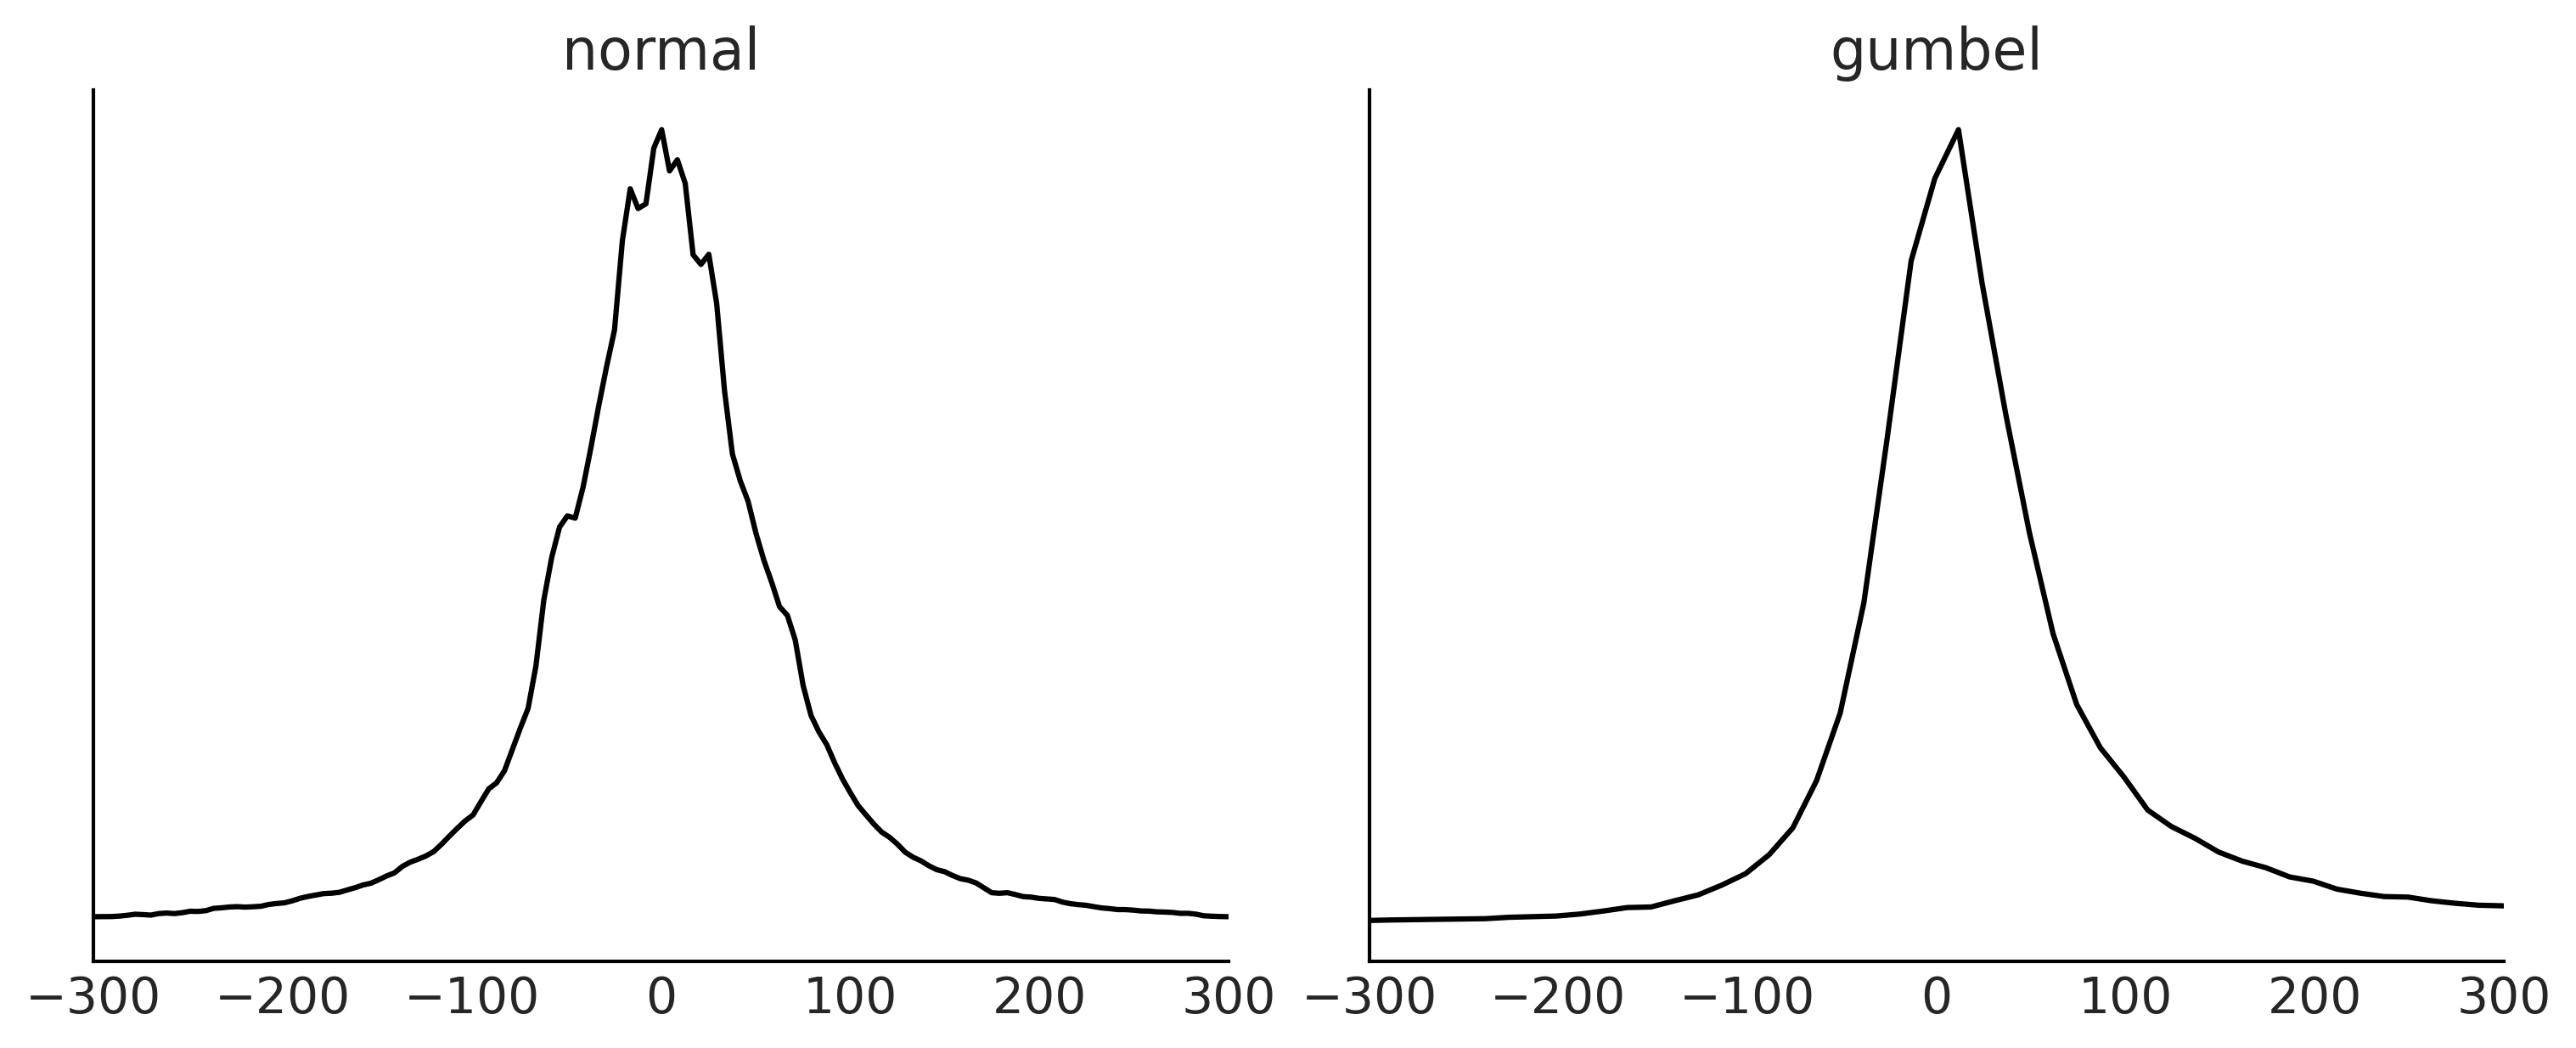

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

prior_predictives = {"normal":normal_prior_predictive, "gumbel": gumbel_predictive }

for i, (label, prior_predictive) in enumerate(prior_predictives.items()):
    
    data = prior_predictive["delays"].flatten()
    az.plot_dist(data, ax=axes[i])
    axes[i].set_yticks([])
    axes[i].set_xlim(-300, 300)
    axes[i].set_title(label)
    
fig.savefig("img/chp09/Airline_Prior_Predictive.png")

## Inference Diagnostics


/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_36222/700159645.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  normal_delay_trace = pm.sample(random_seed=0, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


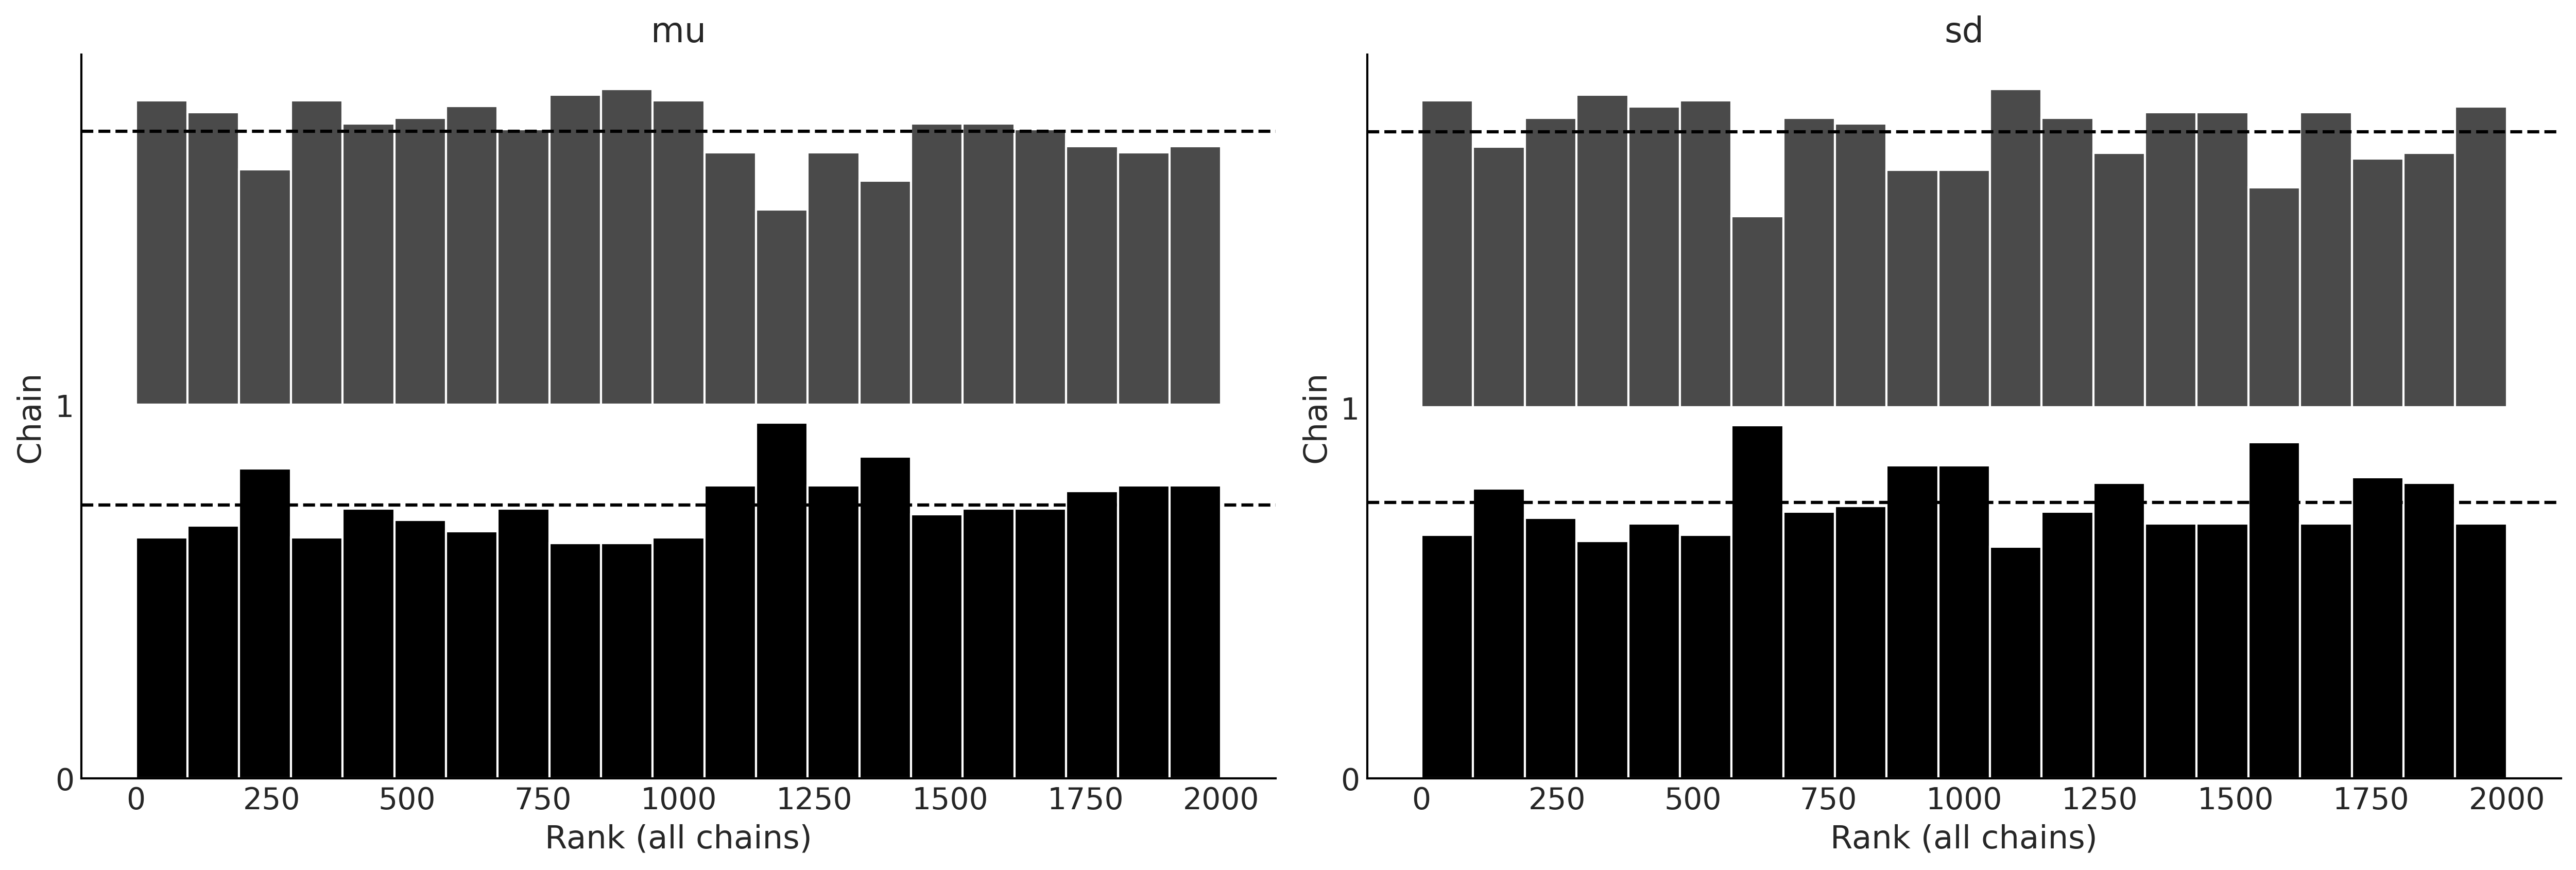

In [10]:
with normal_model:
    normal_delay_trace = pm.sample(random_seed=0, chains=2)
    az.plot_rank(normal_delay_trace)
plt.savefig('img/chp09/rank_plot_bars_normal.png')

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_36222/173437934.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  gumbel_delay_trace = pm.sample(random_seed=0, chains=2, draws=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, beta]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.880925781176837, but should be close to 0.8. Try to increase the number of tuning steps.


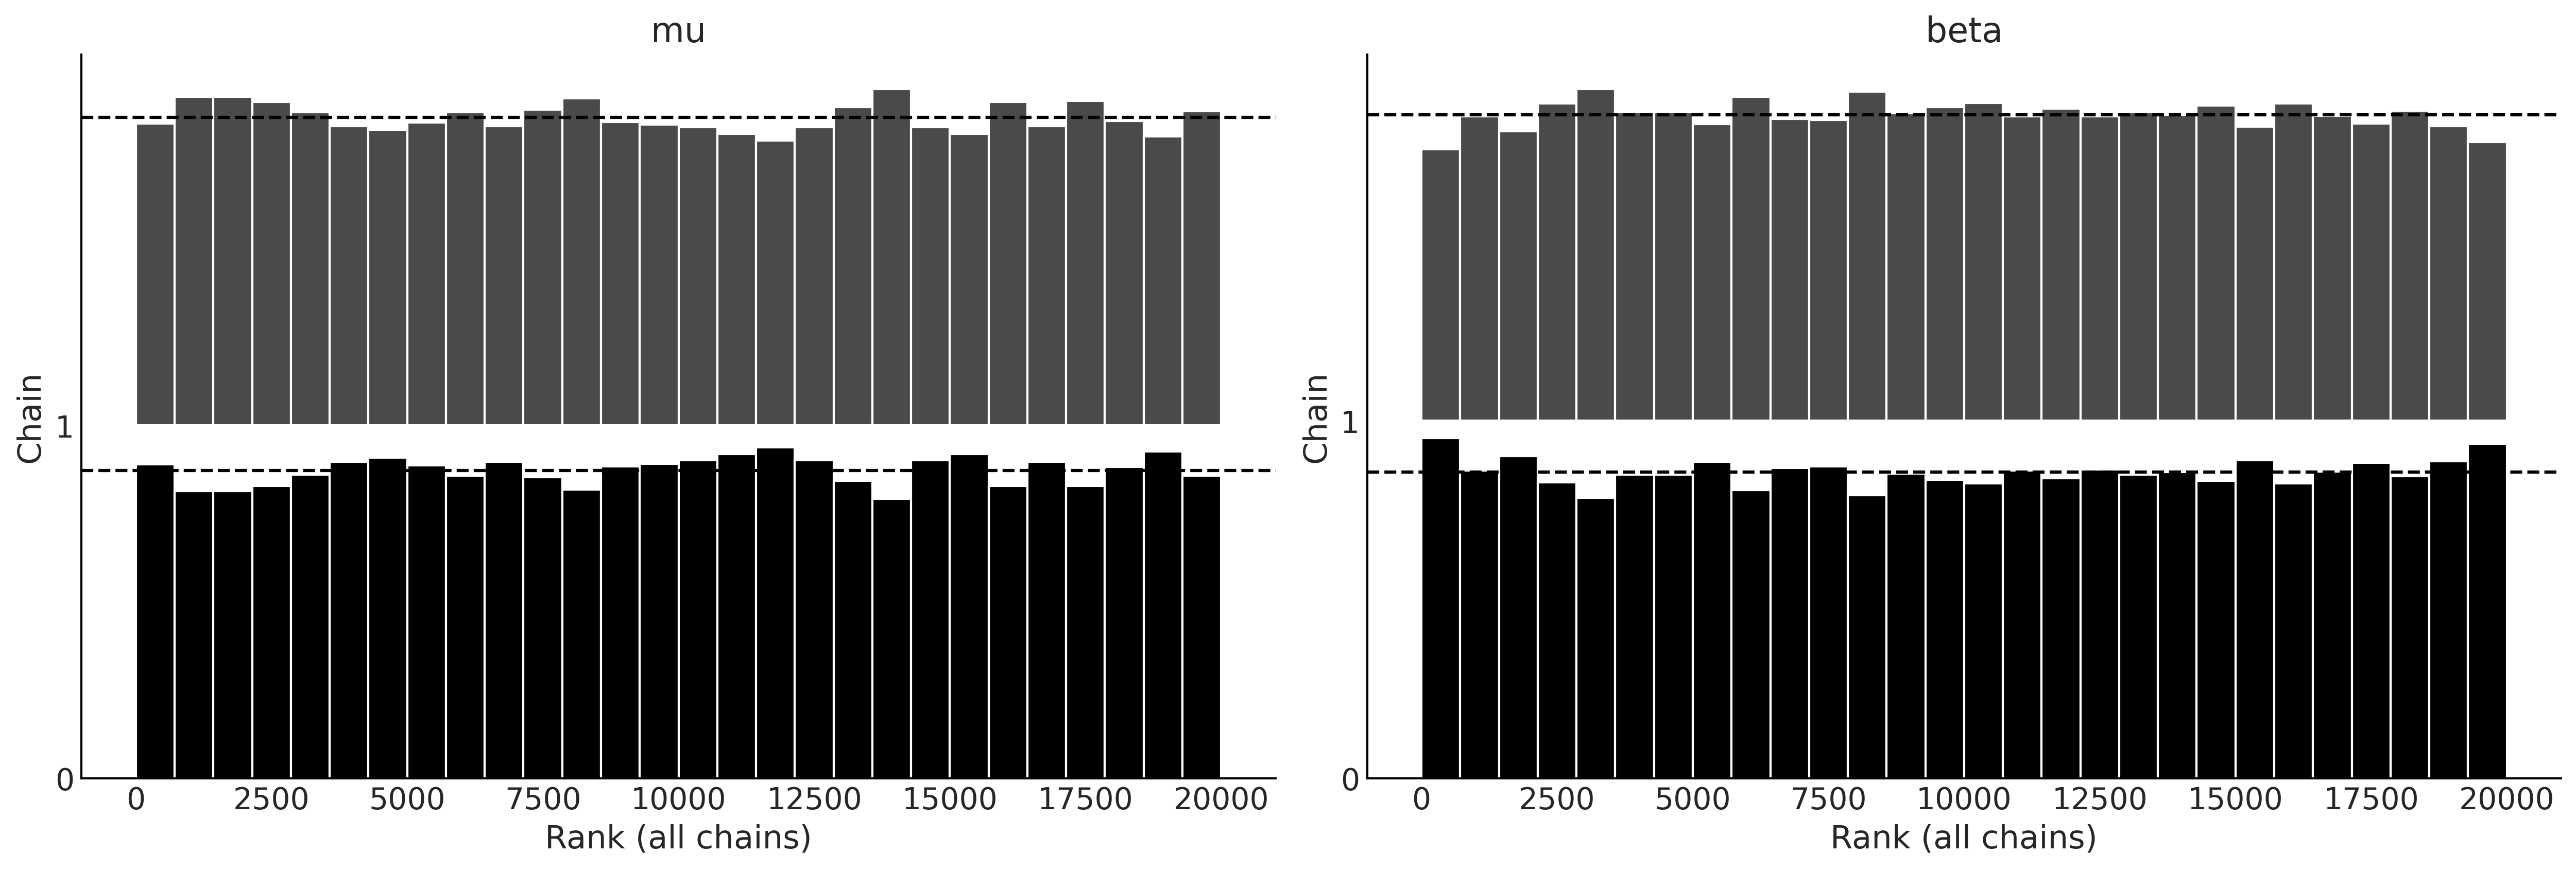

In [11]:
with gumbel_model:
    gumbel_delay_trace = pm.sample(random_seed=0, chains=2, draws=10000)
    az.plot_rank(gumbel_delay_trace)
plt.savefig('img/chp09/rank_plot_bars_gumbel.png')

## Posterior Plots

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


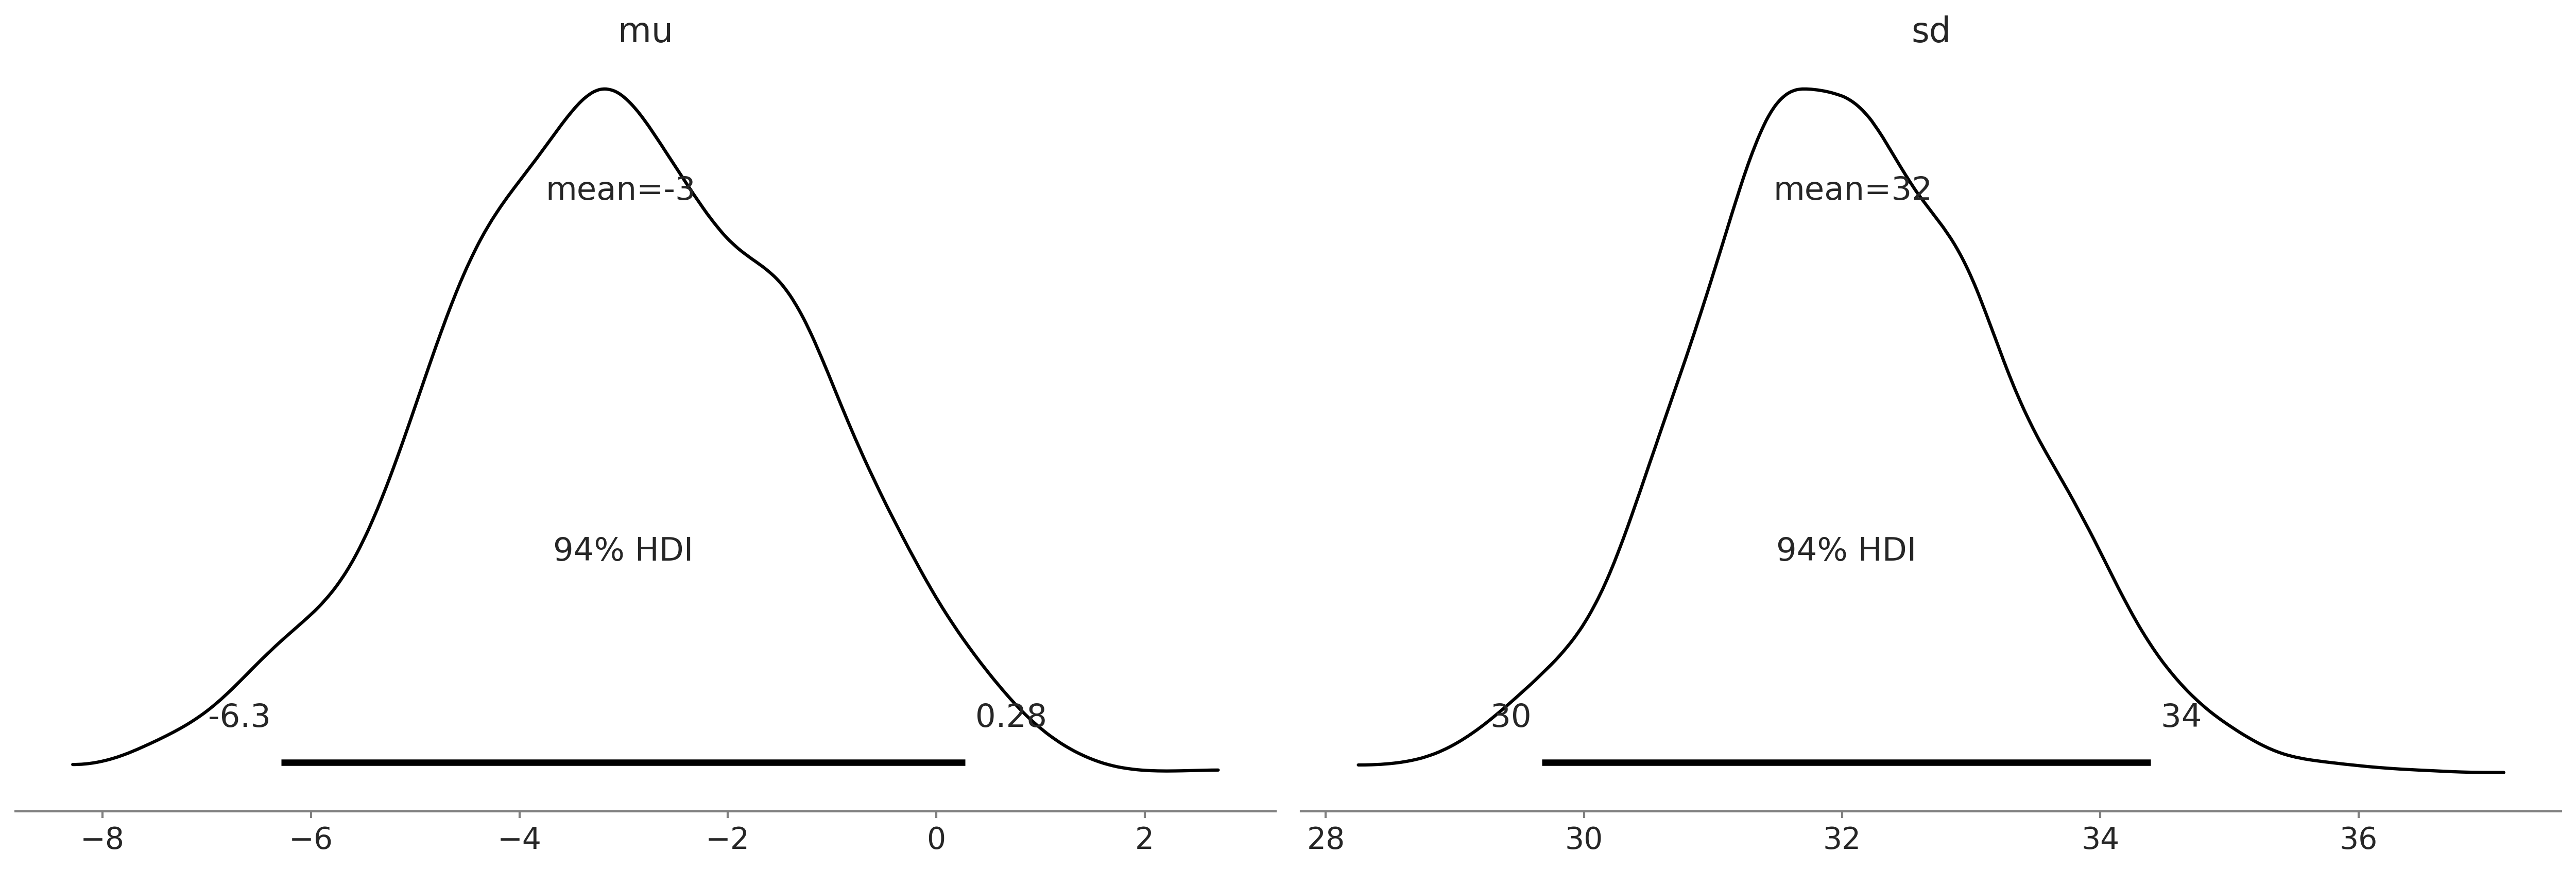

In [12]:
az.plot_posterior(normal_delay_trace)
plt.savefig('img/chp09/posterior_plot_delays_normal.png');

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


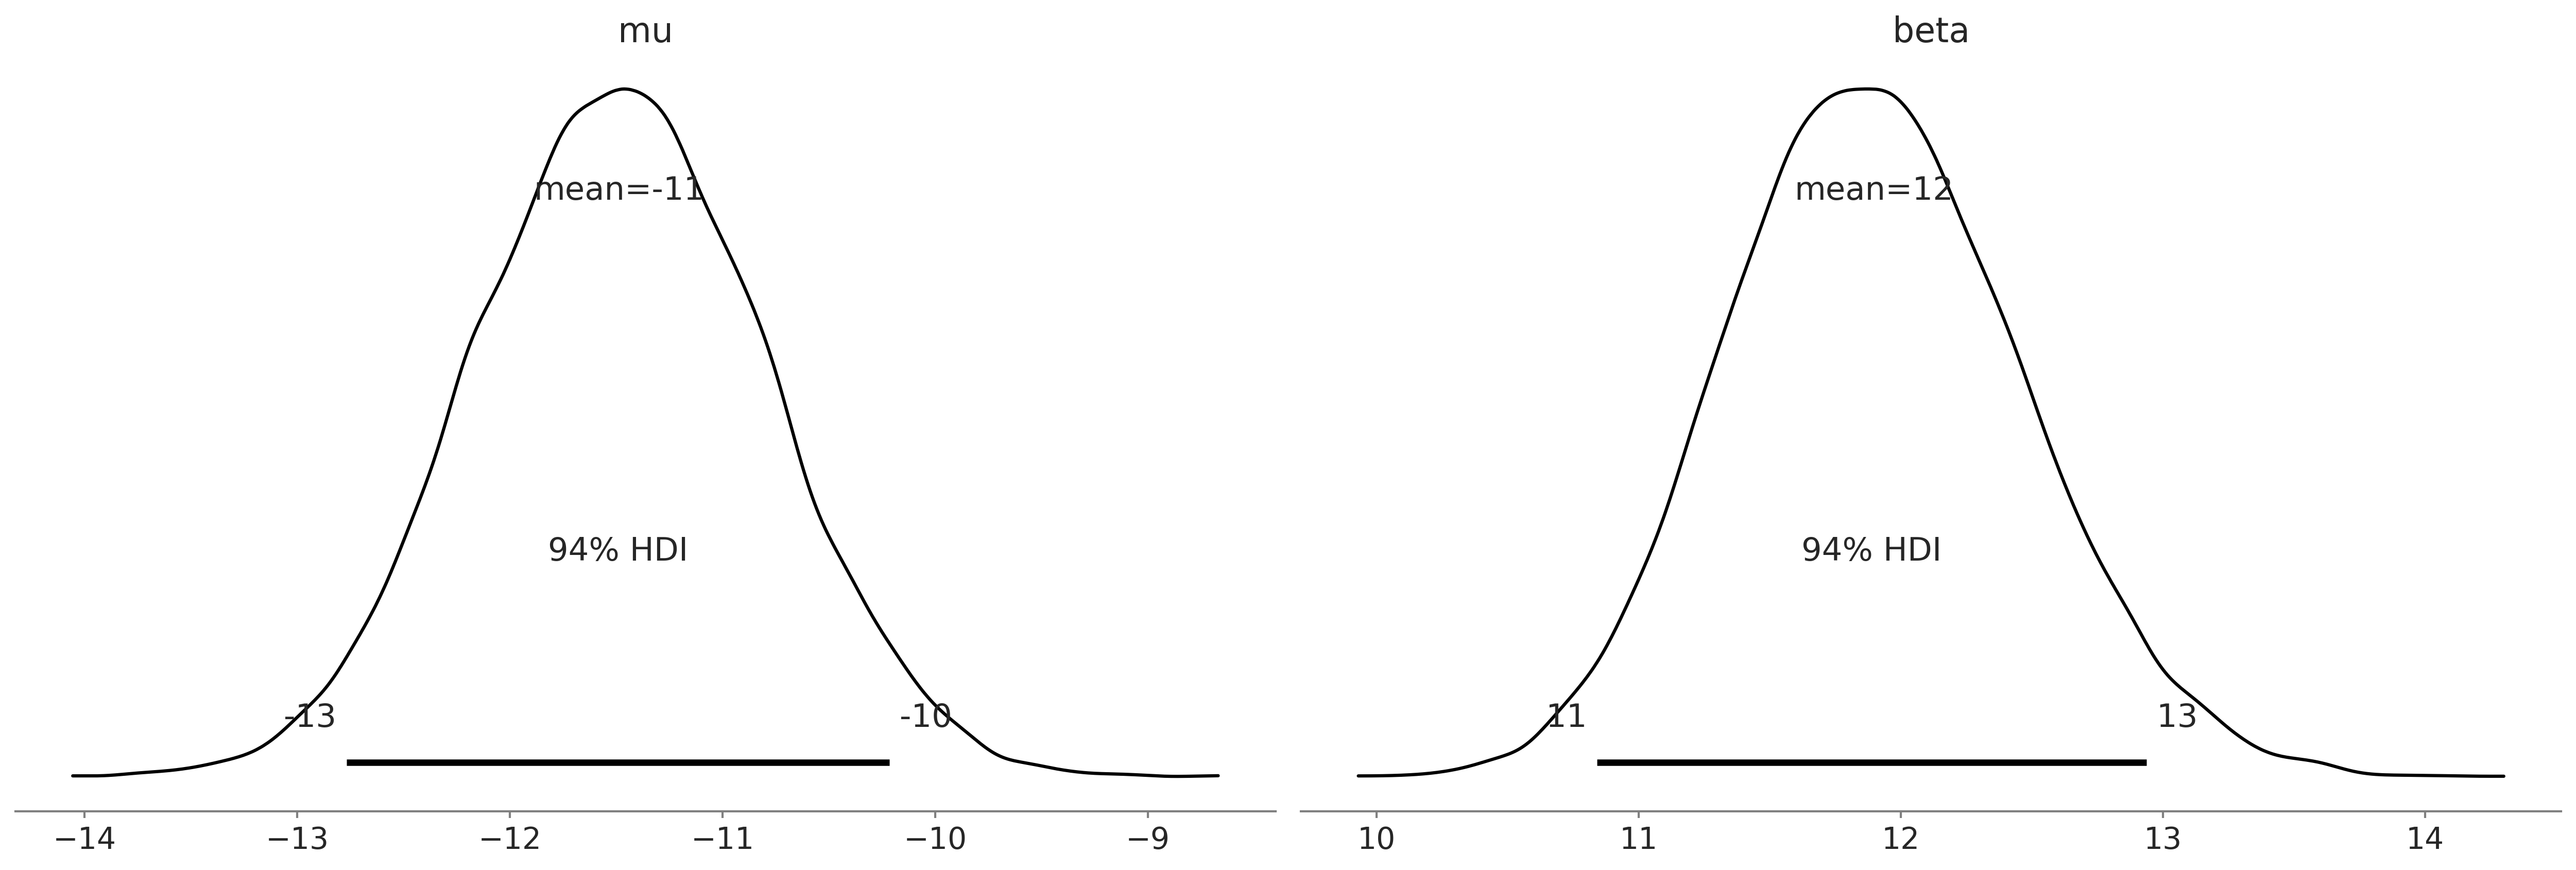

In [13]:
az.plot_posterior(gumbel_delay_trace)
plt.savefig('img/chp09/posterior_plot_delays_gumbel.png');

## Posterior Predictive Plots

### Normal Posterior Predictive

In [14]:
with normal_model:
    normal_delay_trace = pm.sample(random_seed=0)
    normal_post_pred_check = pm.sample_posterior_predictive(normal_delay_trace, random_seed=0)
    normal_data = az.from_pymc3(trace=normal_delay_trace, posterior_predictive=normal_post_pred_check)

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_36222/2703936732.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  normal_delay_trace = pm.sample(random_seed=0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


array([<AxesSubplot:xlabel='delays'>], dtype=object)

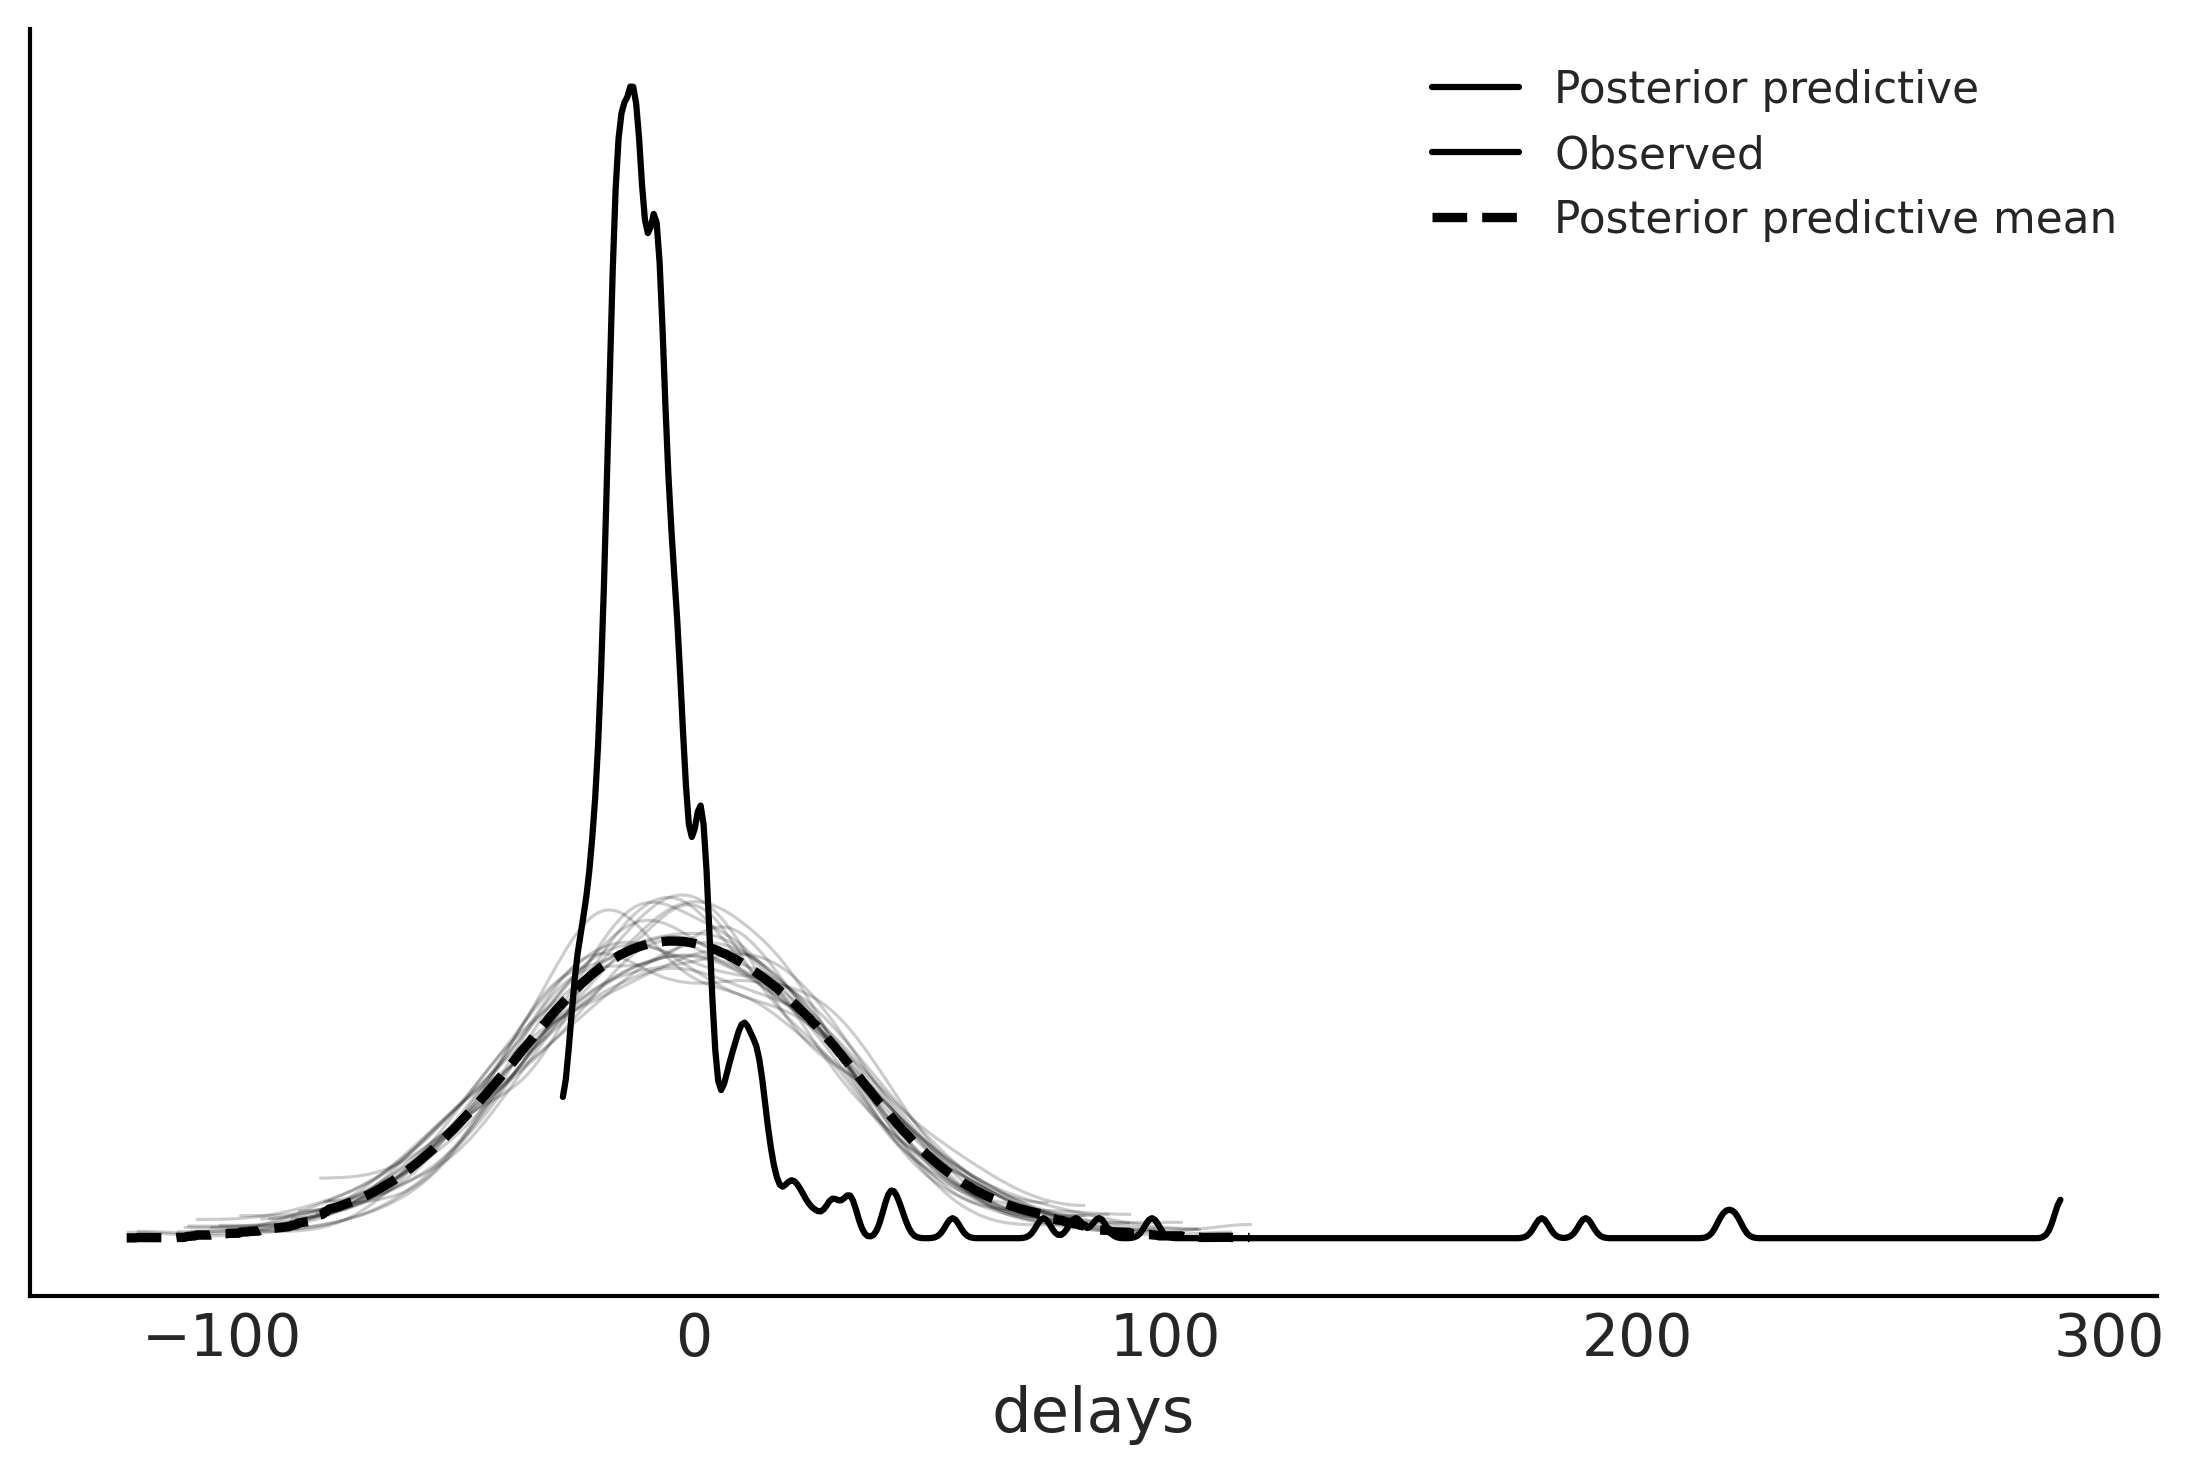

In [15]:
fig, ax = plt.subplots()
az.plot_ppc(normal_data, observed=True, num_pp_samples=20, ax=ax)

## Gumbel Posterior Predictive

In [16]:
with gumbel_model:
    gumbel_post_pred_check = pm.sample_posterior_predictive(gumbel_delay_trace, random_seed=0)
    gumbel_data = az.from_pymc3(trace=gumbel_delay_trace, posterior_predictive=gumbel_post_pred_check)

In [17]:
gumbel_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

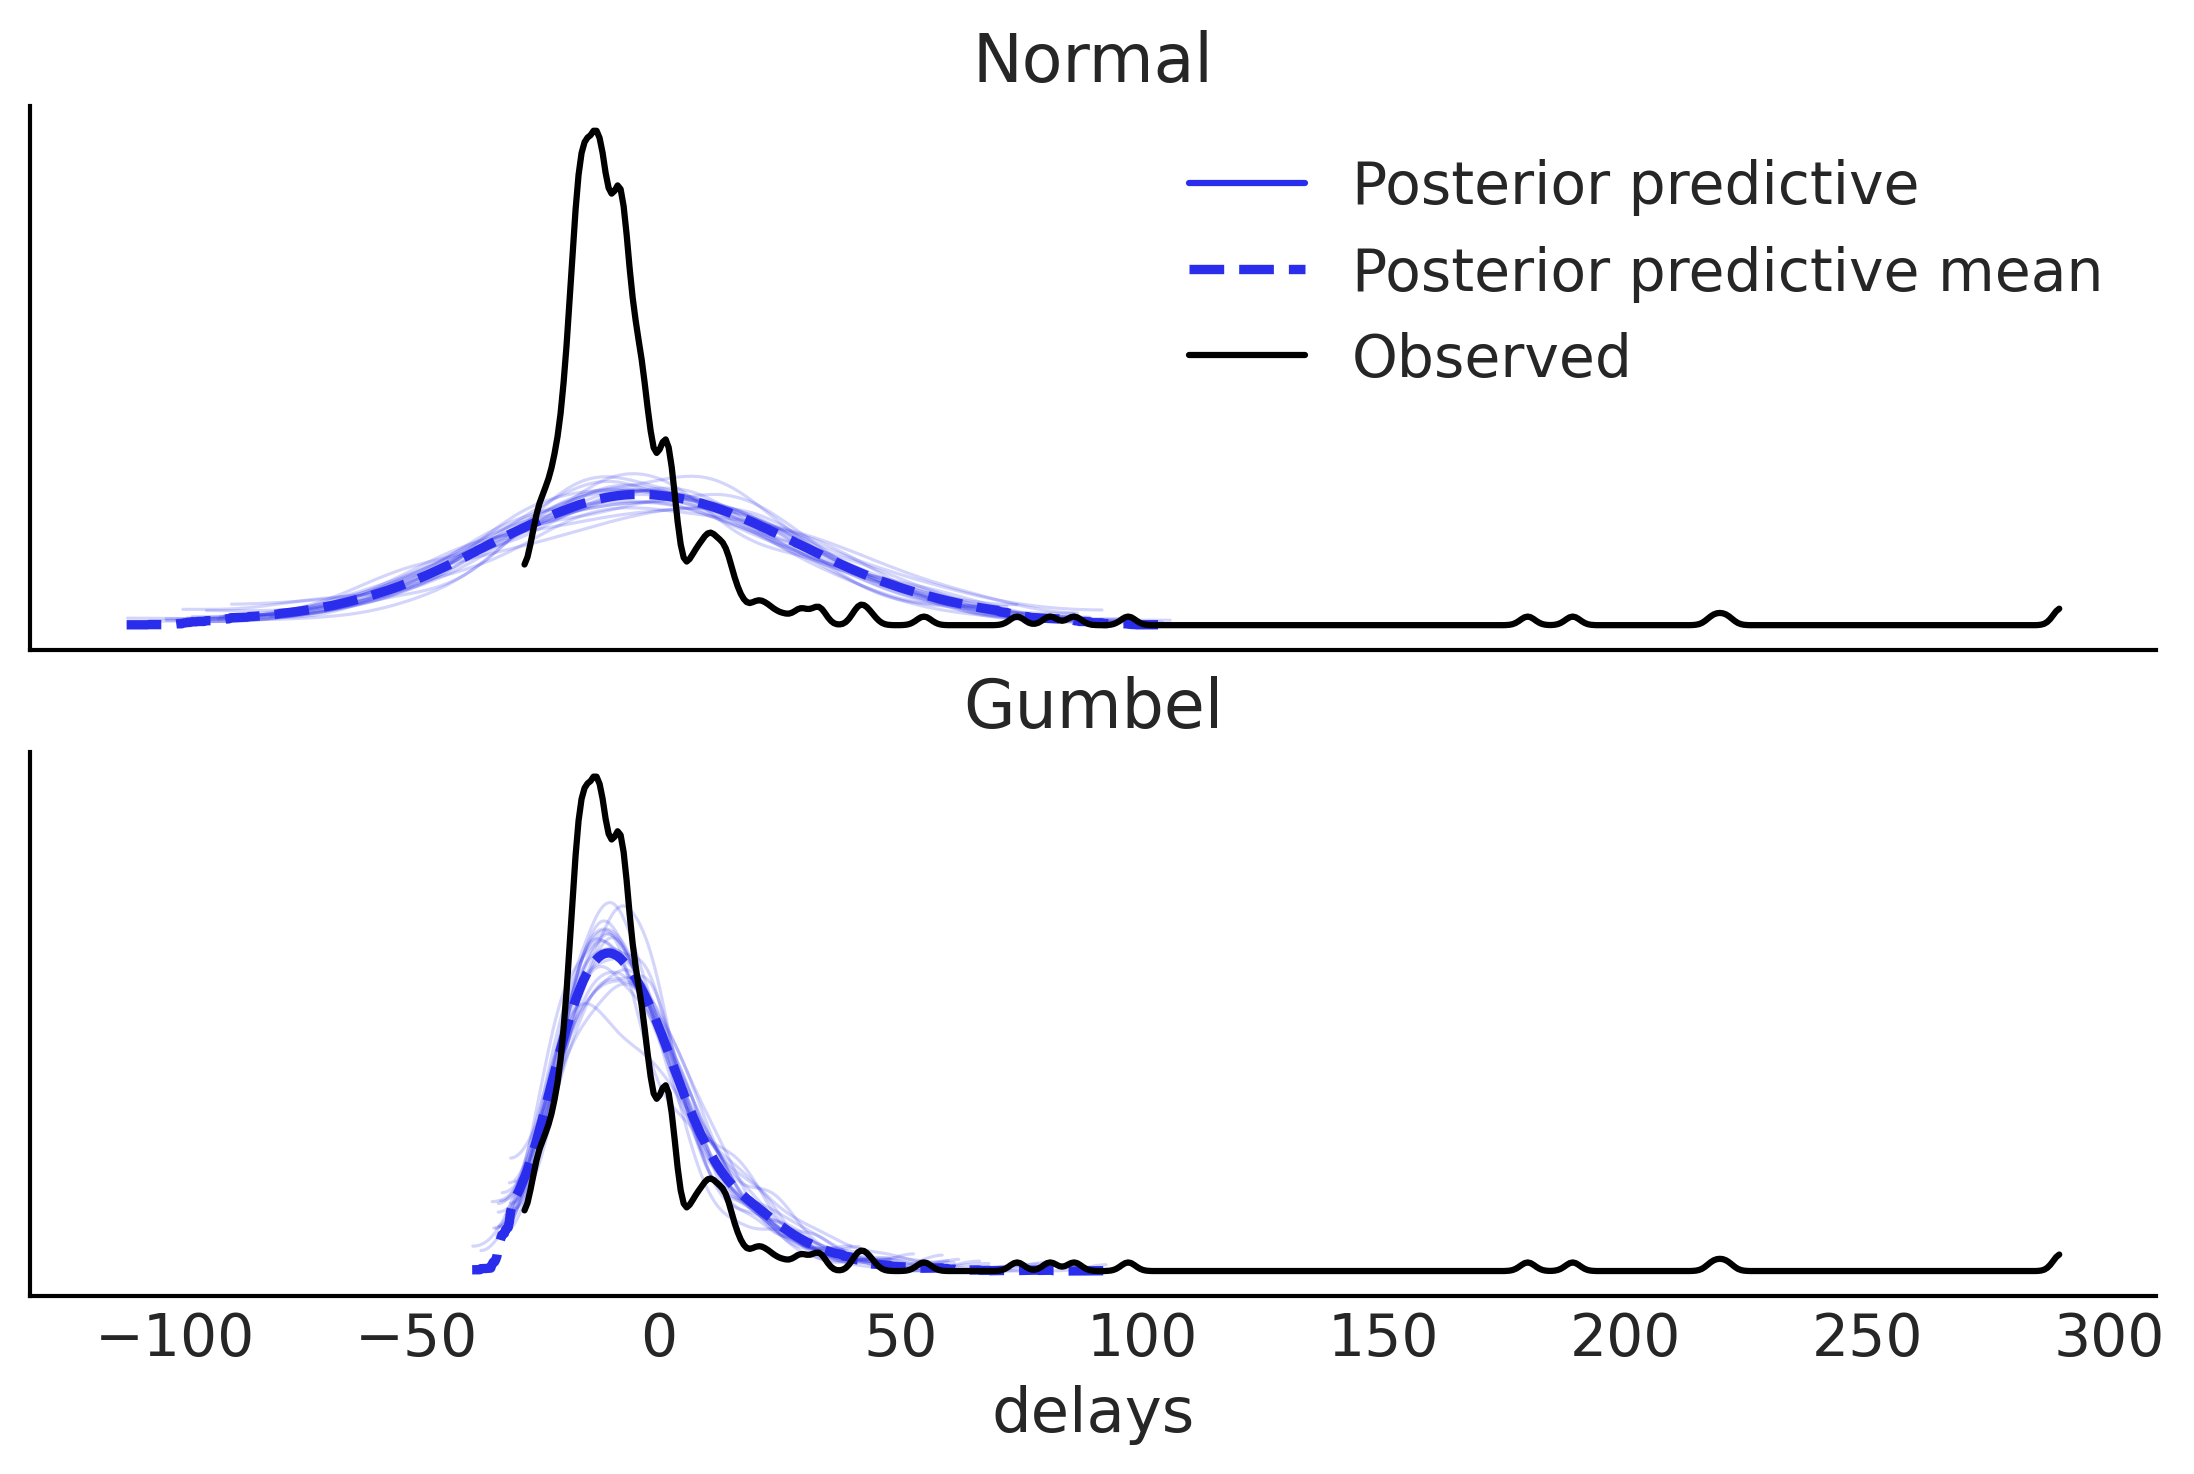

In [18]:
fig, ax = plt.subplots(2,1, sharex=True)

az.plot_ppc(normal_data, observed=False, num_pp_samples=20, ax=ax[0], color="C4")
az.plot_kde(msn_arrivals, ax=ax[0], label="Observed");

az.plot_ppc(gumbel_data, observed=False, num_pp_samples=20, ax=ax[1], color="C4")
az.plot_kde(msn_arrivals, ax=ax[1], label="Observed");
ax[0].set_title("Normal")
ax[0].set_xlabel("")
ax[1].set_title("Gumbel")
ax[1].legend().remove()
plt.savefig("img/chp09/delays_model_posterior_predictive.png")

## Test Statistics

In [19]:
gumbel_late = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()
dist_of_late = (gumbel_late > 0).sum(axis=1) / 336

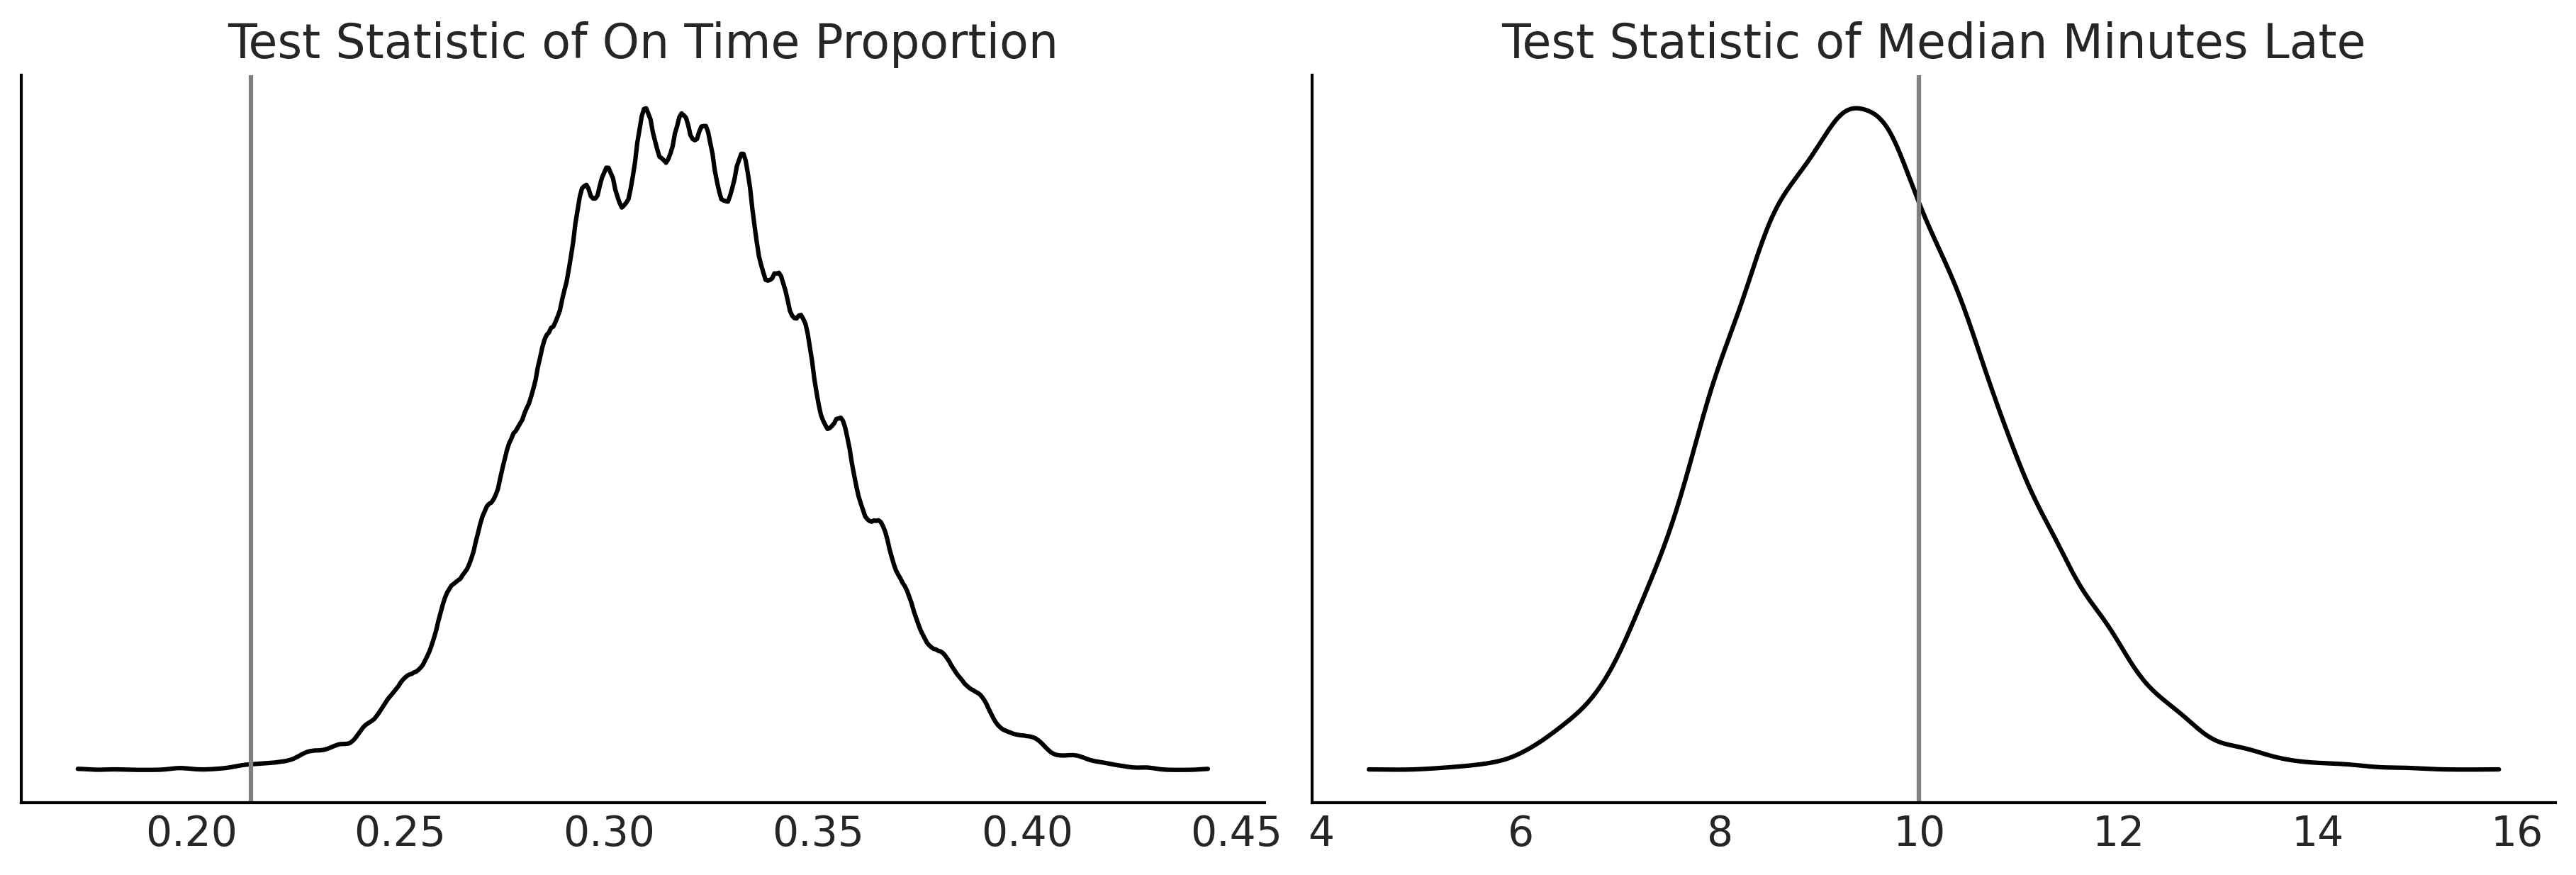

In [20]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

gumbel_late = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()
dist_of_late = (gumbel_late > 0).sum(axis=1) / 336
az.plot_dist(dist_of_late, ax=axes[0])

percent_observed_late = (msn_arrivals > 0).sum() / 336
axes[0].axvline(percent_observed_late, c="gray")
axes[0].set_title("Test Statistic of On Time Proportion")
axes[0].set_yticks([])


gumbel_late[gumbel_late < 0] = np.nan
median_lateness = np.nanmedian(gumbel_late, axis=1)
az.plot_dist(median_lateness,  ax=axes[1])

median_time_observed_late = msn_arrivals[msn_arrivals >= 0].median()
axes[1].axvline(median_time_observed_late, c="gray")
axes[1].set_title("Test Statistic of Median Minutes Late")
axes[1].set_yticks([])

plt.savefig("img/chp09/arrival_test_statistics_for_gumbel_posterior_predictive.png")

## LOO PIT Comparison

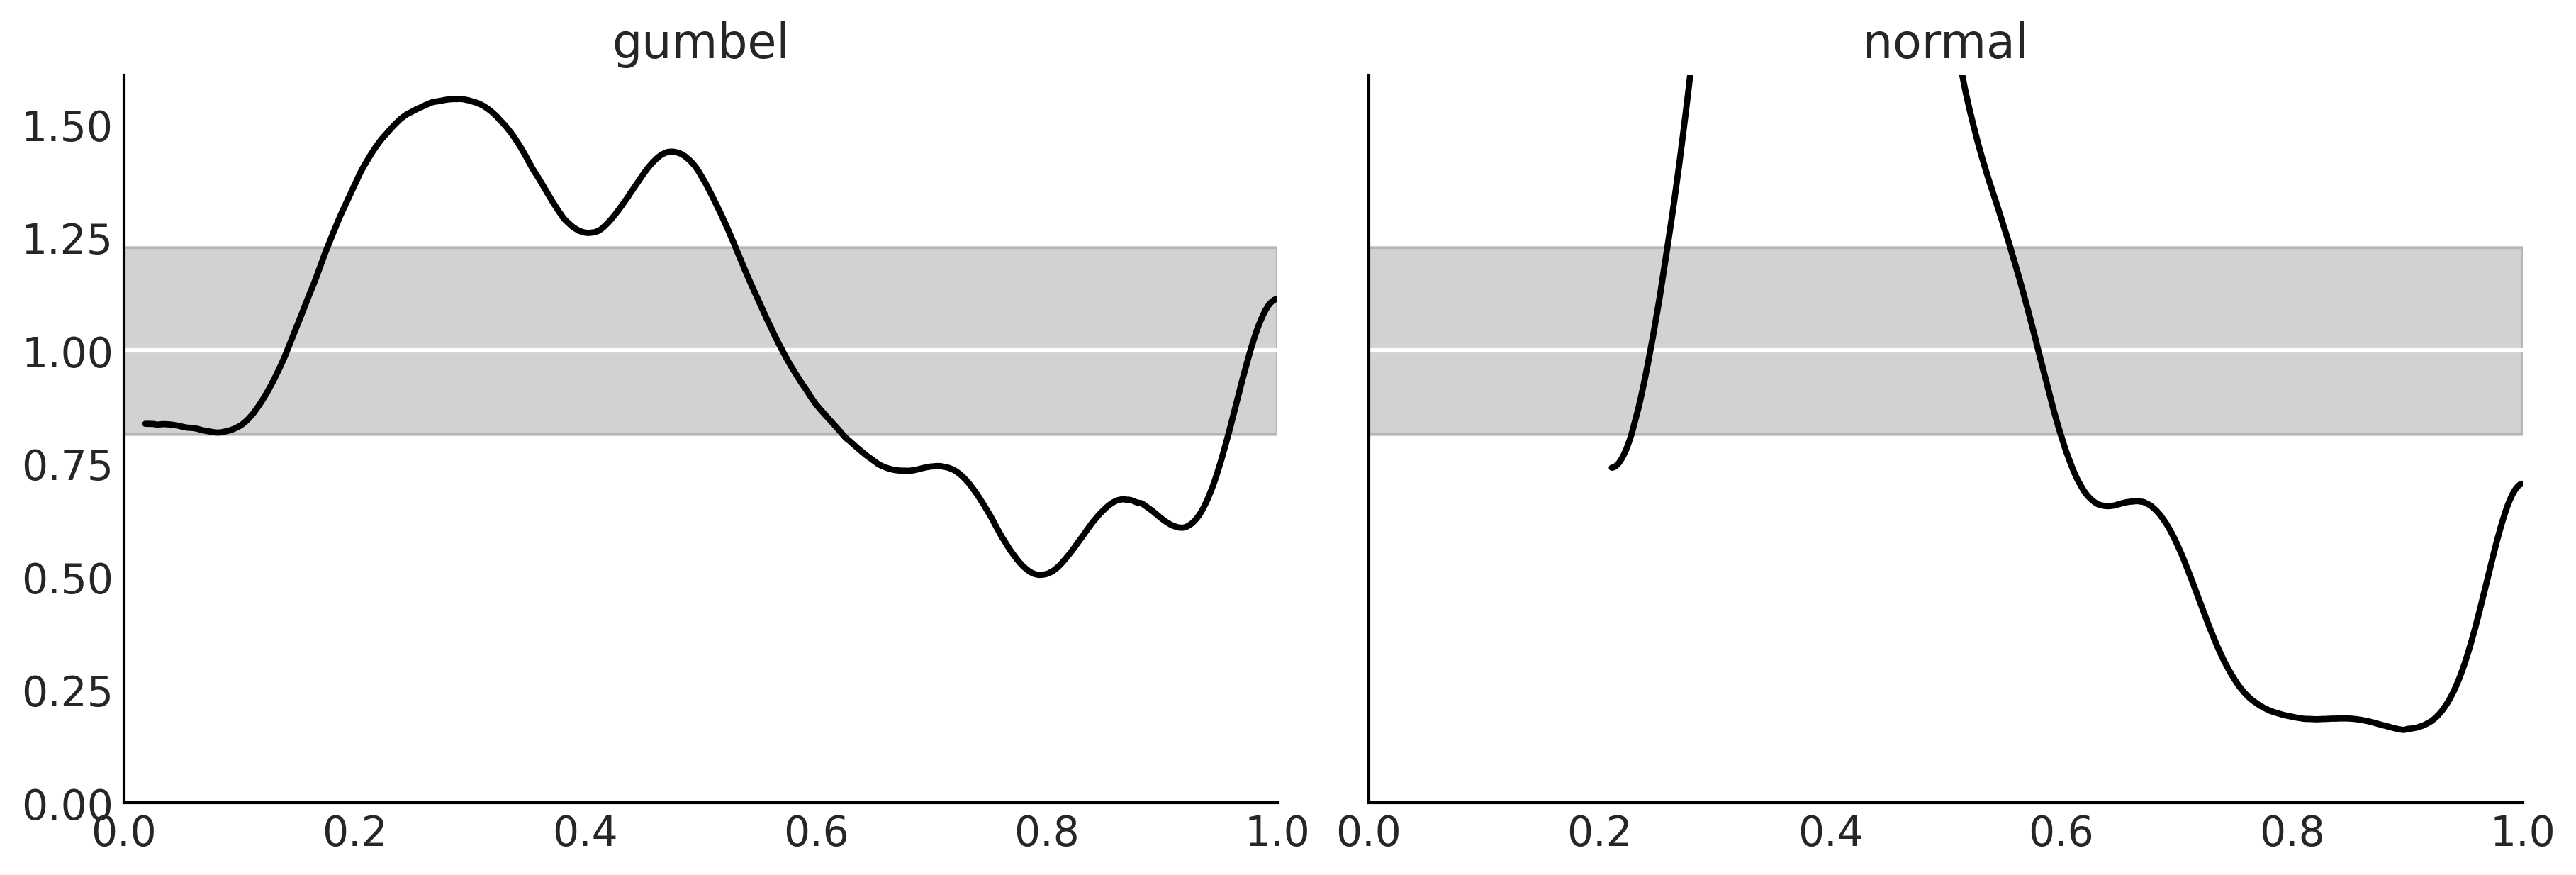

In [21]:
_, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for label, model, ax in zip(("gumbel", "normal"),(gumbel_data, normal_data), axes):
    az.plot_loo_pit(model, y="delays", legend=False, use_hdi=True, ax=ax)
    ax.set_title(label)
    
plt.savefig('img/chp09/loo_pit_delays.png')

In [22]:


cmp_dict = {"gumbel": gumbel_data,
            "normal": normal_data}
            
cmp = az.compare(cmp_dict)

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


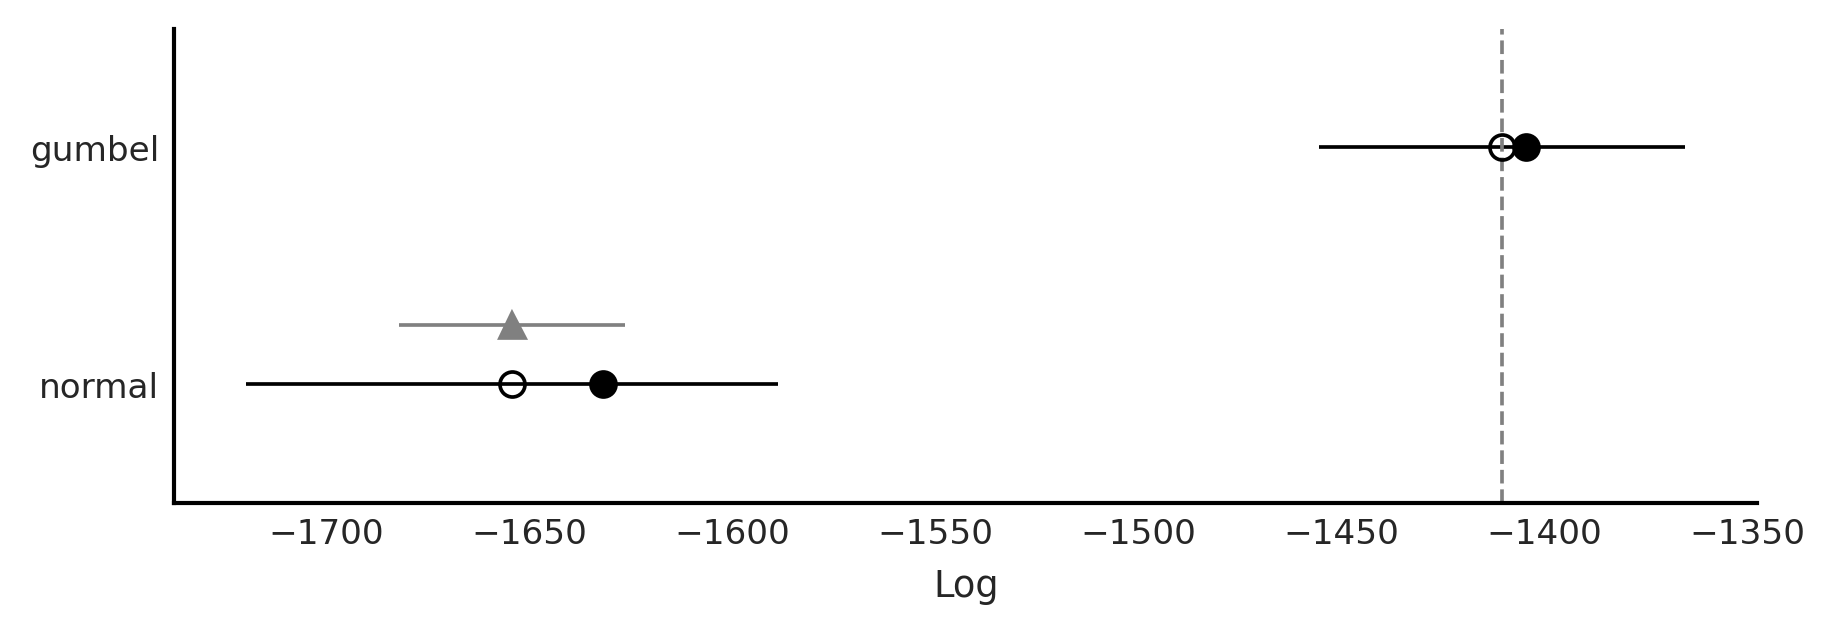

In [47]:
az.plot_compare(cmp)
plt.savefig("img/chp09/model_comparison_airlines.png")

## ELPD Plot

In [24]:
gumbel_loo = az.loo(gumbel_data, pointwise=True)
normal_loo = az.loo(normal_data, pointwise=True)

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


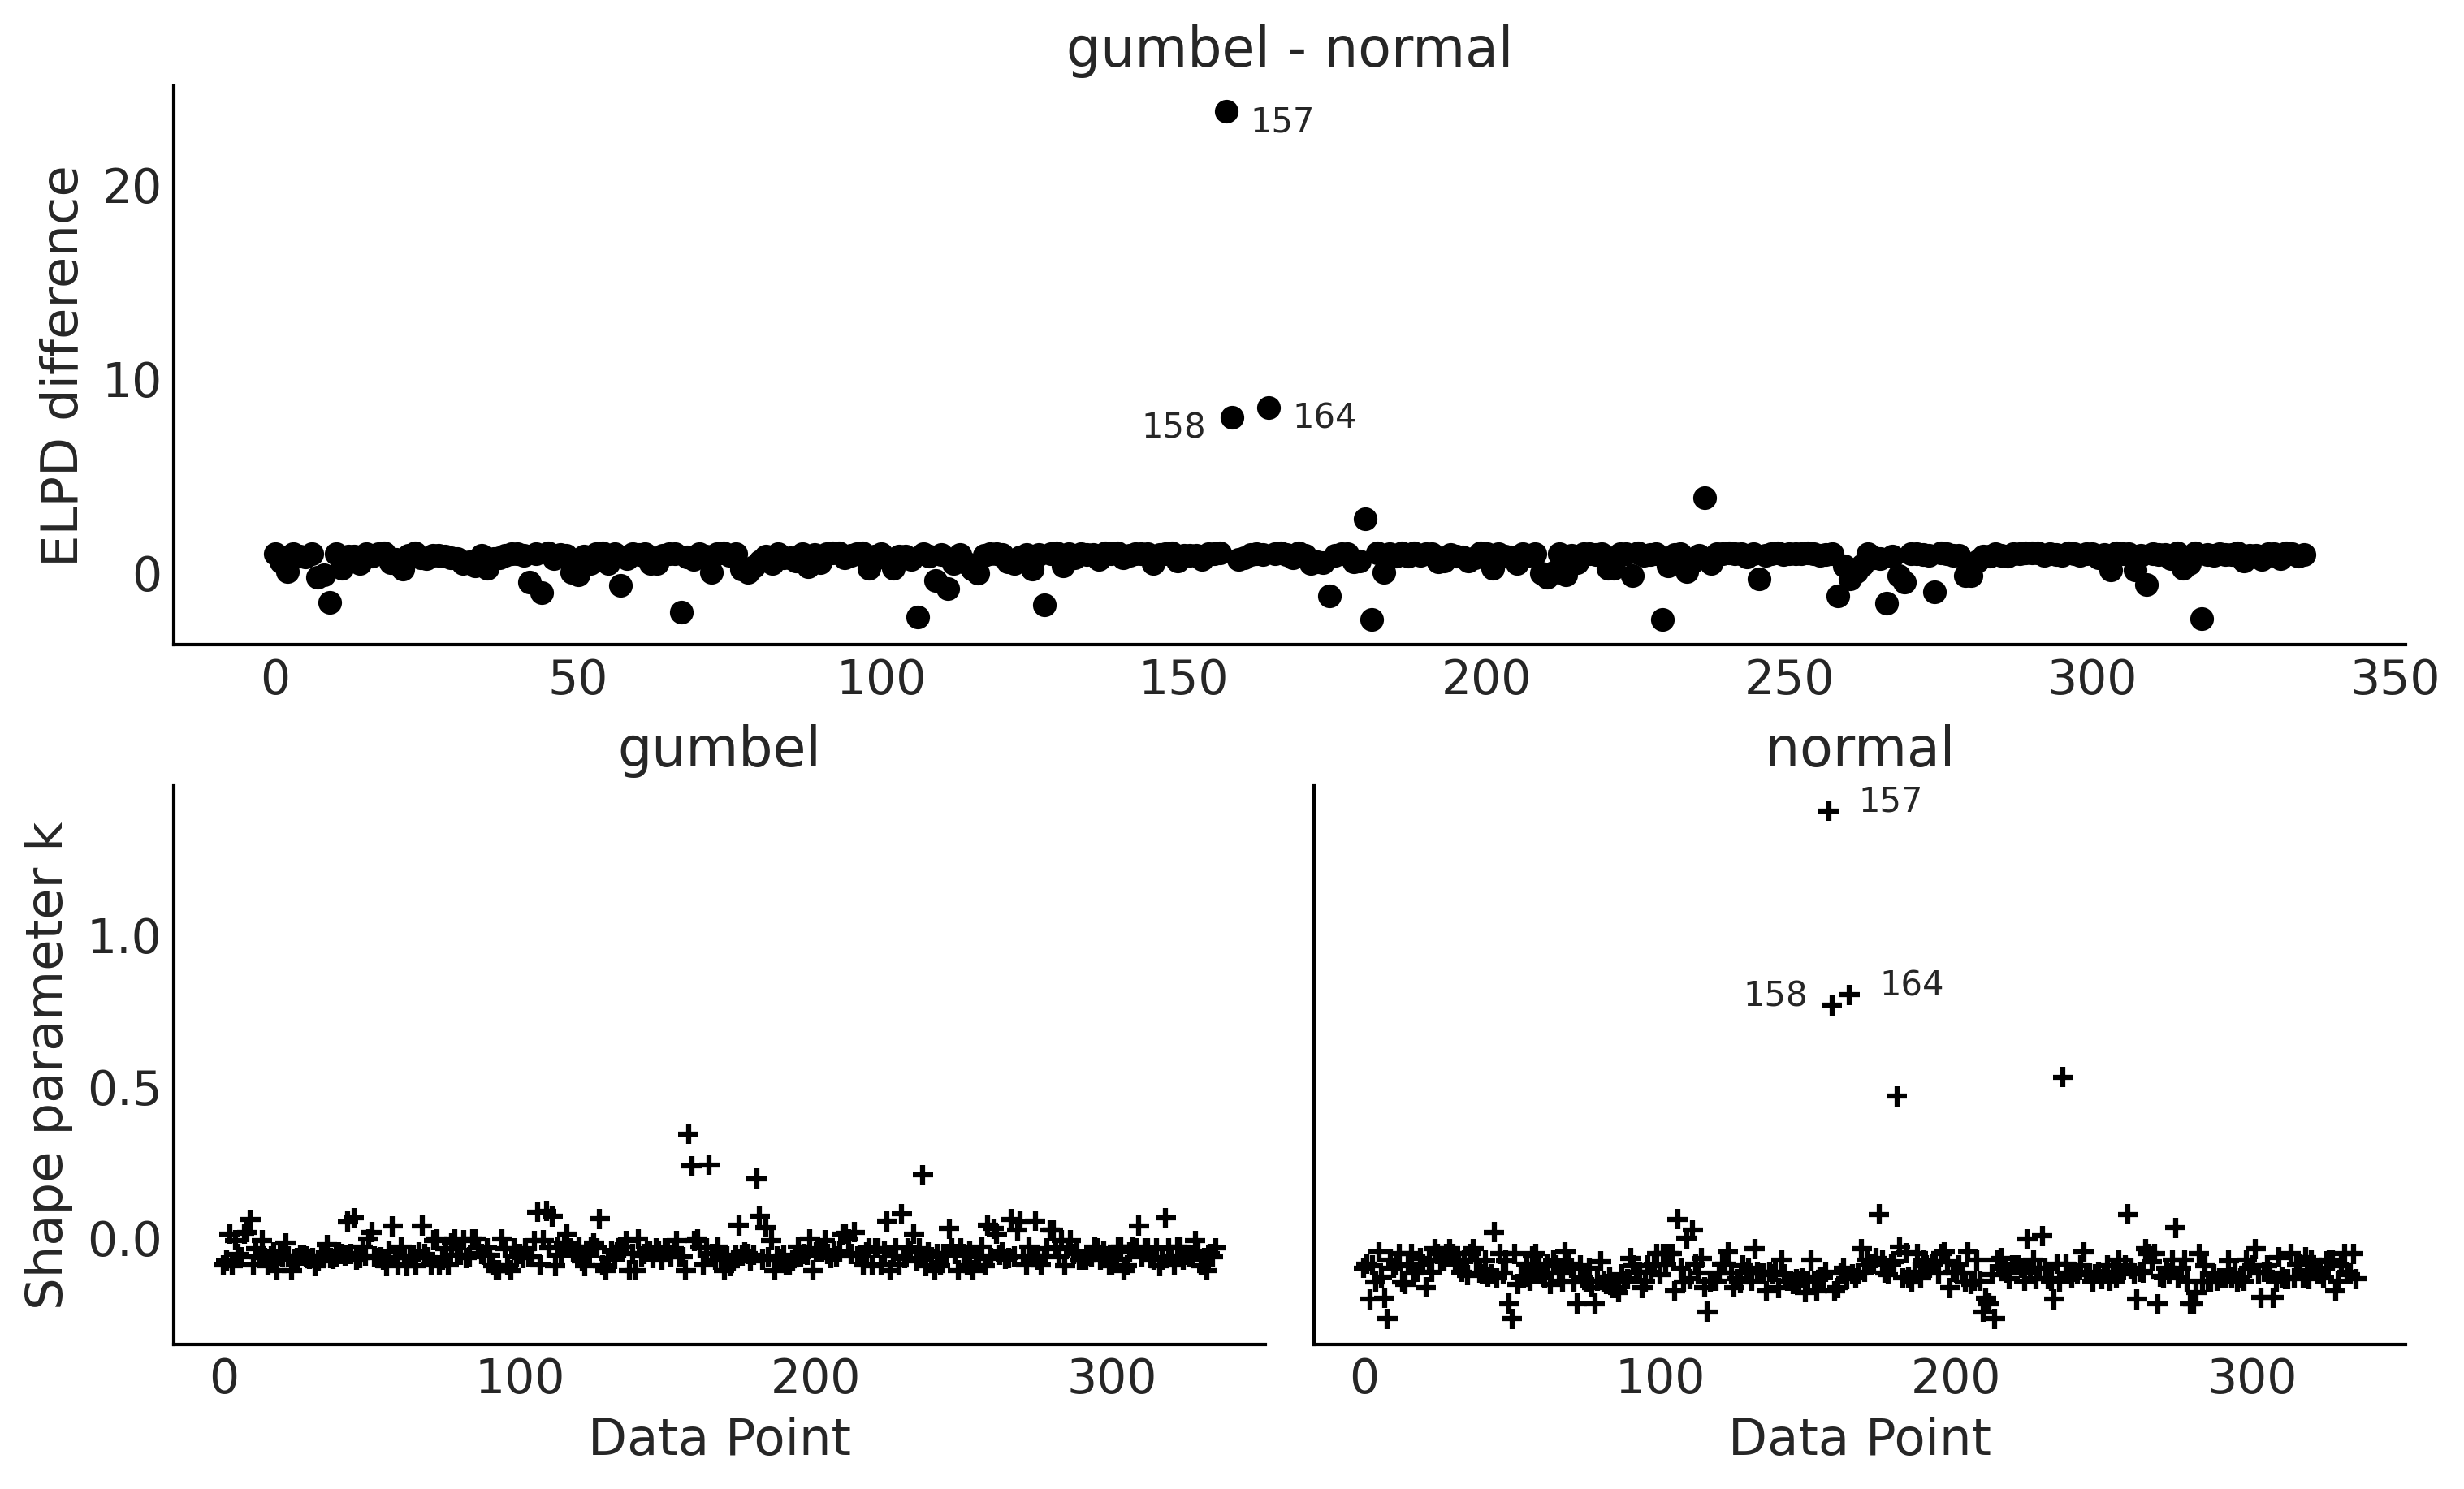

In [25]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])


diff = gumbel_loo.loo_i - normal_loo.loo_i
idx = np.abs(diff) > 4
x_values = np.where(idx)[0]
y_values = diff[idx].values
az.plot_elpd(cmp_dict, ax=ax)

for x, y, in zip(x_values, y_values):
    if x != 158:
        x_pos = x+4
    else:
        x_pos = x-15
    ax.text(x_pos, y-1, x)
    
for label, elpd_data, ax in zip(("gumbel", "normal"),
                                (gumbel_loo, normal_loo), (ax1, ax2)):
    az.plot_khat(elpd_data, ax=ax)
    ax.set_title(label)
    idx = elpd_data.pareto_k > 0.7
    x_values = np.where(idx)[0]
    y_values = elpd_data.pareto_k[idx].values
    for x, y, in zip(x_values, y_values):
        if x != 158:
            x_pos = x+10
        else:
            x_pos = x-30
        ax.text(x_pos, y, x)
    

#     ttl = ax.title
#    ttl.set_position([.5, 10])

ax1.set_ylim(ax2.get_ylim())
ax2.set_ylabel("")
ax2.set_yticks([])
plt.savefig('img/chp09/elpd_plot_delays.png');

## Reward functions

In [26]:
posterior_pred = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()

In [27]:
@np.vectorize
def current_revenue(delay):
    """Calculates revenue """
    if delay >= 0:
        return 300*delay
    return np.nan

In [28]:
def revenue_calculator(posterior_pred, revenue_func):    
    revenue_per_flight = revenue_func(posterior_pred)
    average_revenue = np.nanmean(revenue_per_flight)
    return revenue_per_flight, average_revenue

In [29]:
revenue_per_flight, average_revenue = revenue_calculator(posterior_pred, current_revenue)
average_revenue

3926.9756861830815

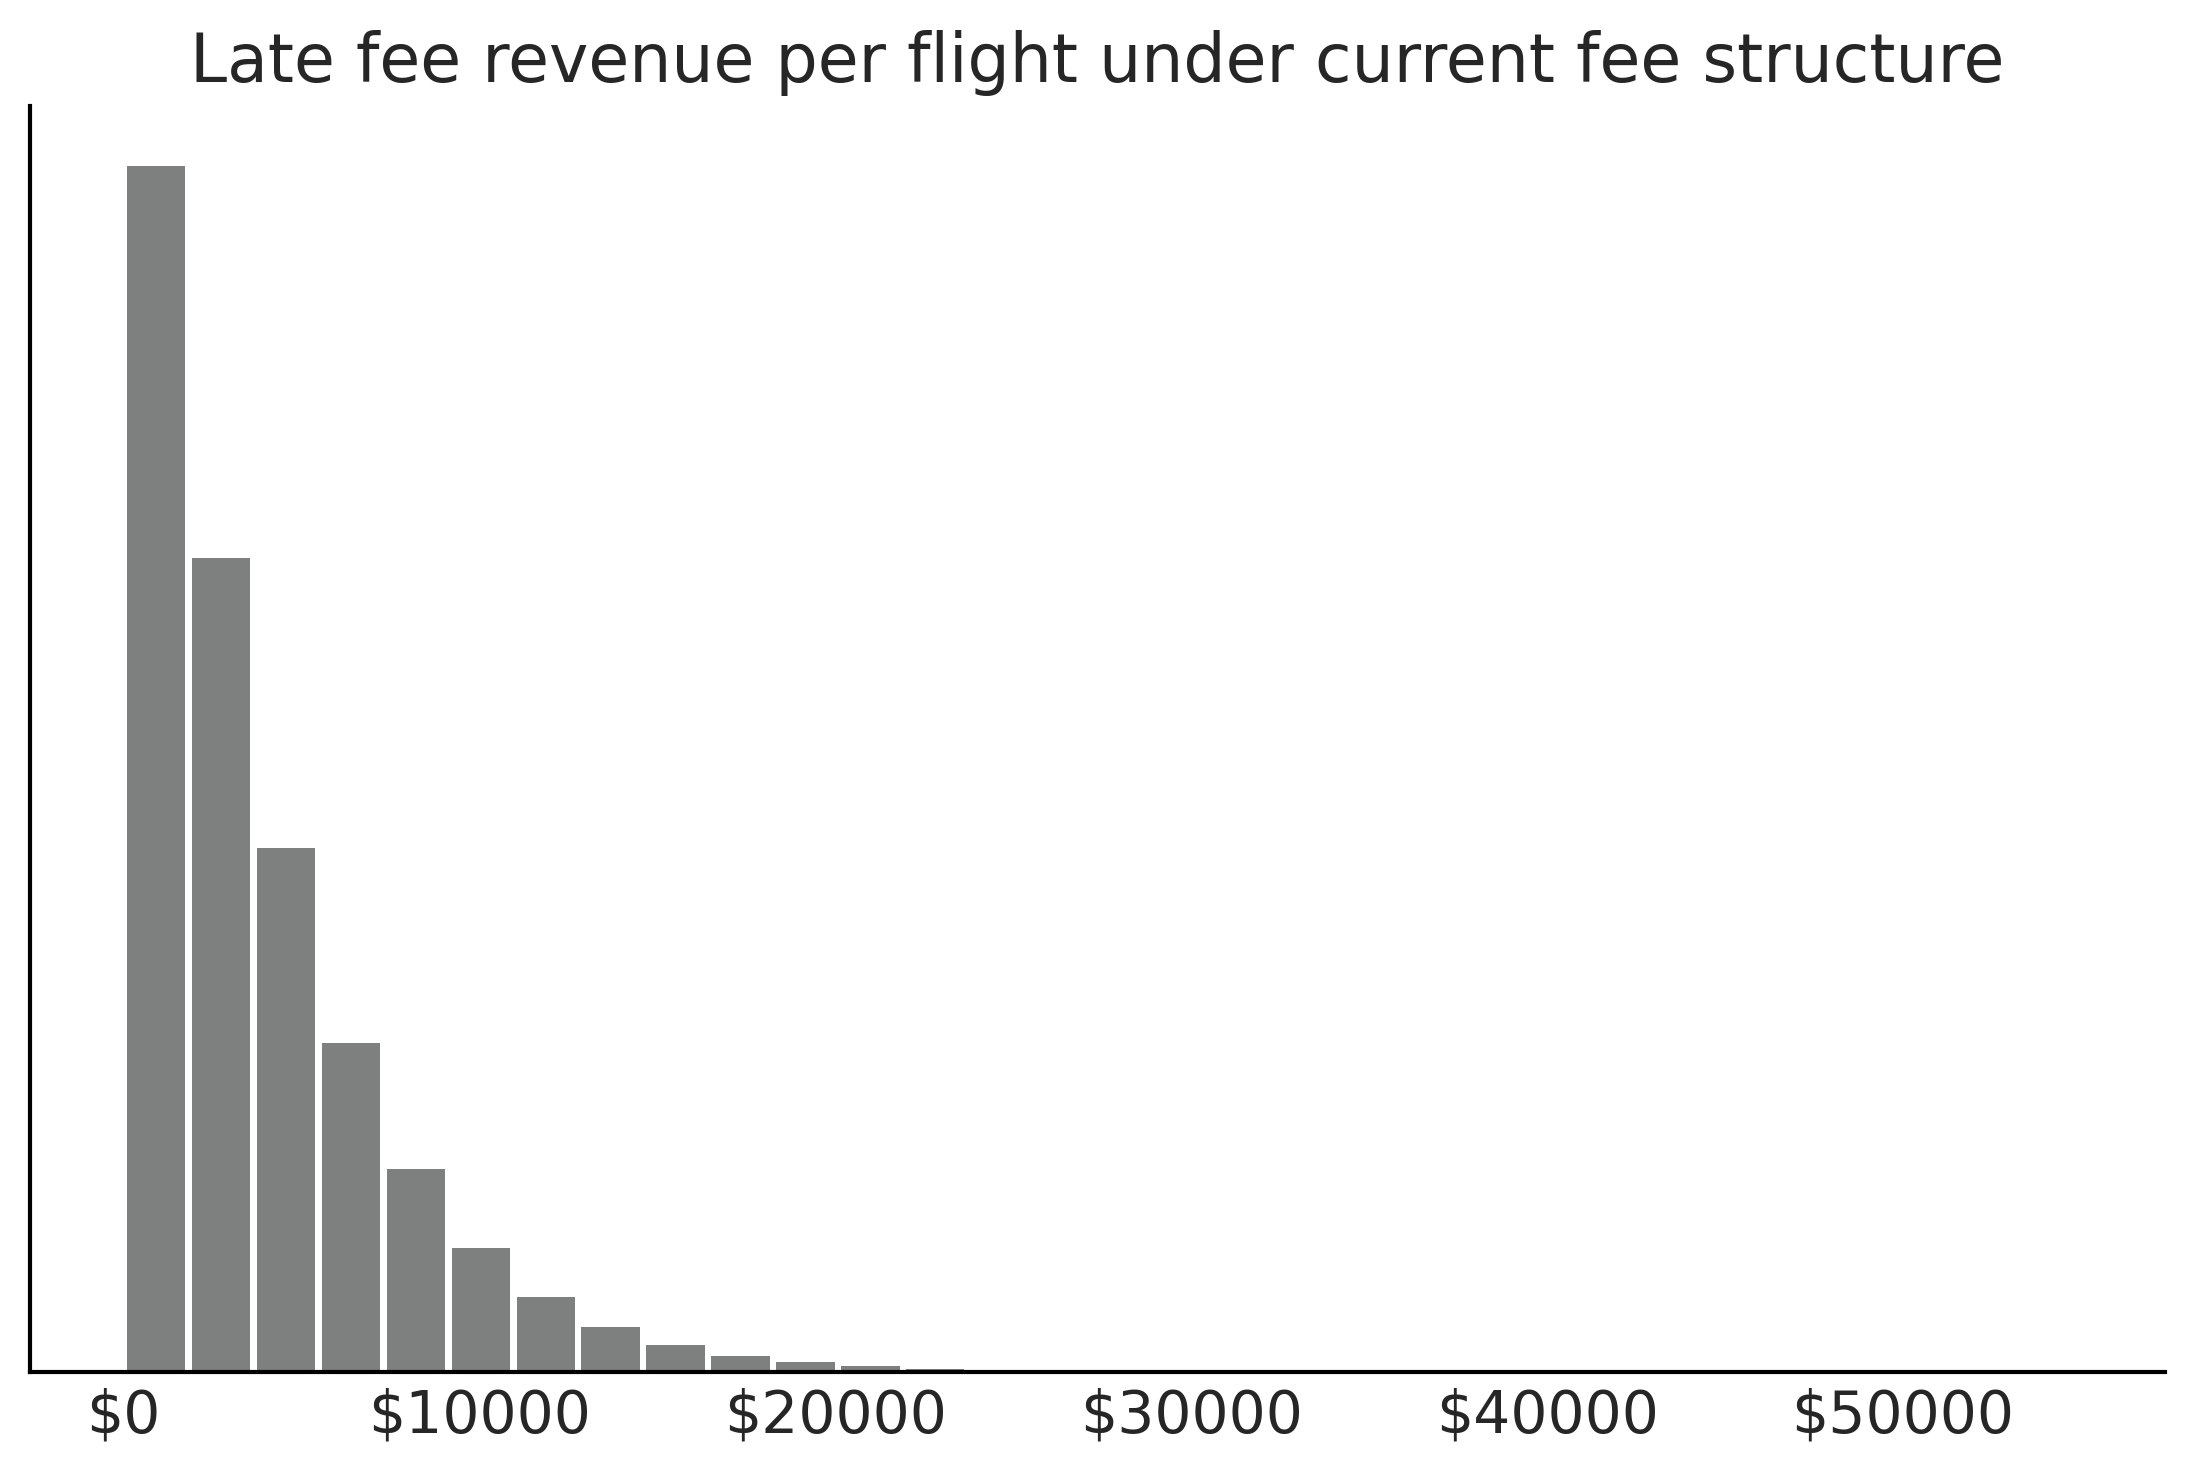

In [30]:
fig, ax = plt.subplots()
ax.hist(revenue_per_flight.flatten(), bins=30, rwidth=.9, color="C2" )
ax.set_yticks([])
ax.set_title("Late fee revenue per flight under current fee structure")
ax.xaxis.set_major_formatter('${x:1.0f}')
plt.savefig("img/chp09/late_fee_current_structure_hist.png")

In [31]:
@np.vectorize
def proposed_revenue(delay):
    """Calculates revenue """
    if delay >= 100:
        return 30000
    elif delay >= 10:
        return 5000
    elif delay >= 0:
        return 1000
    else:
        return np.nan

In [32]:
revenue_per_flight_proposed, average_revenue_proposed = revenue_calculator(posterior_pred, proposed_revenue)
average_revenue_proposed

2920.483266761447

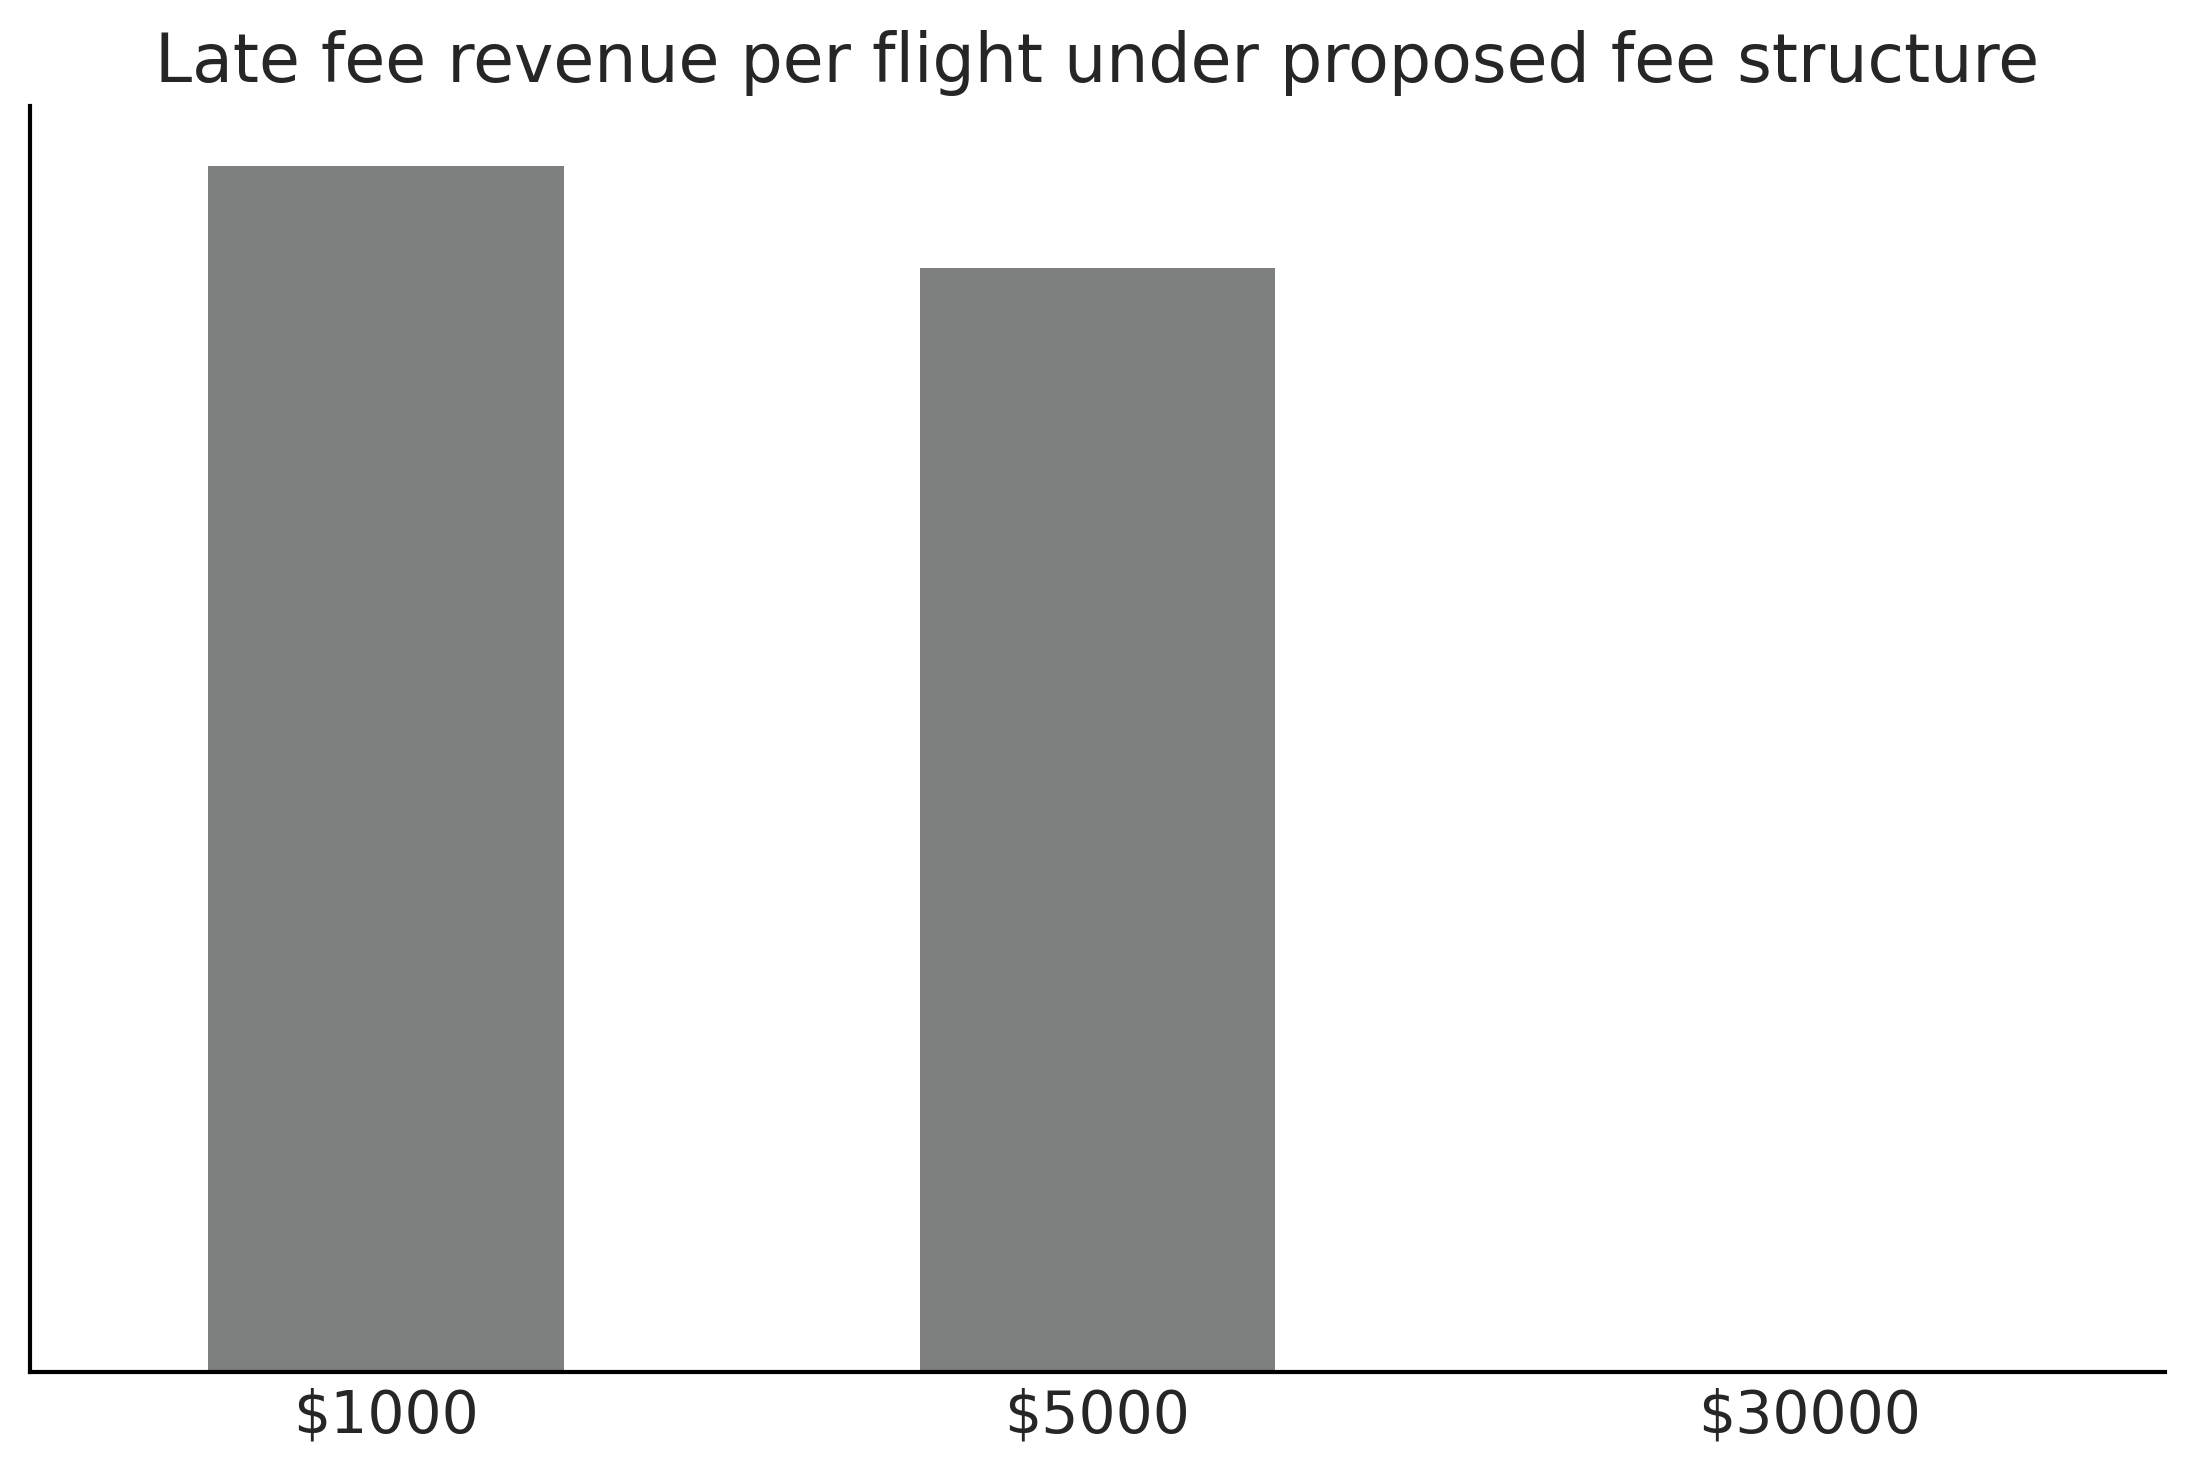

In [33]:
fig, ax = plt.subplots()

counts = pd.Series(revenue_per_flight_proposed.flatten()).value_counts()
counts.index = counts.index.astype(int)

counts.plot(kind="bar", ax=ax, color="C2")
ax.set_title("Late fee revenue per flight under proposed fee structure")
ax.set_yticks([]);
ax.tick_params(axis='x', labelrotation = 0)
ax.set_xticklabels([f"${i}" for i in counts.index])

plt.savefig("img/chp09/late_fee_proposed_structure_hist.png");

In [34]:
counts

1000     1109858
5000     1016516
30000        650
dtype: int64

In [35]:
counts/counts.sum()*100

1000     52.178913
5000     47.790528
30000     0.030559
dtype: float64

## Experimental Examples

In [36]:
composites_df = pd.read_csv("../data/CompositeTensileTest.csv")

In [37]:
unidirectional = composites_df["Unidirectional Ultimate Strength (ksi)"].values
bidirectional = composites_df["Bidirectional Ultimate Strength (ksi)"].values

In [38]:
with pm.Model() as unidirectional_model:
    sd = pm.HalfStudentT("sd_uni", 20)
    mu = pm.Normal("mu_uni", 120, 30)
    
    uni_ksi = pm.Normal("uni_ksi", mu=mu, sd=sd, observed=unidirectional)
    
    # prior_uni = pm.sample_prior_predictive()
    trace = pm.sample(draws=5000)
    
uni_data = az.from_pymc3(trace=trace)

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_36222/4059400571.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_uni, sd_uni]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.
/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


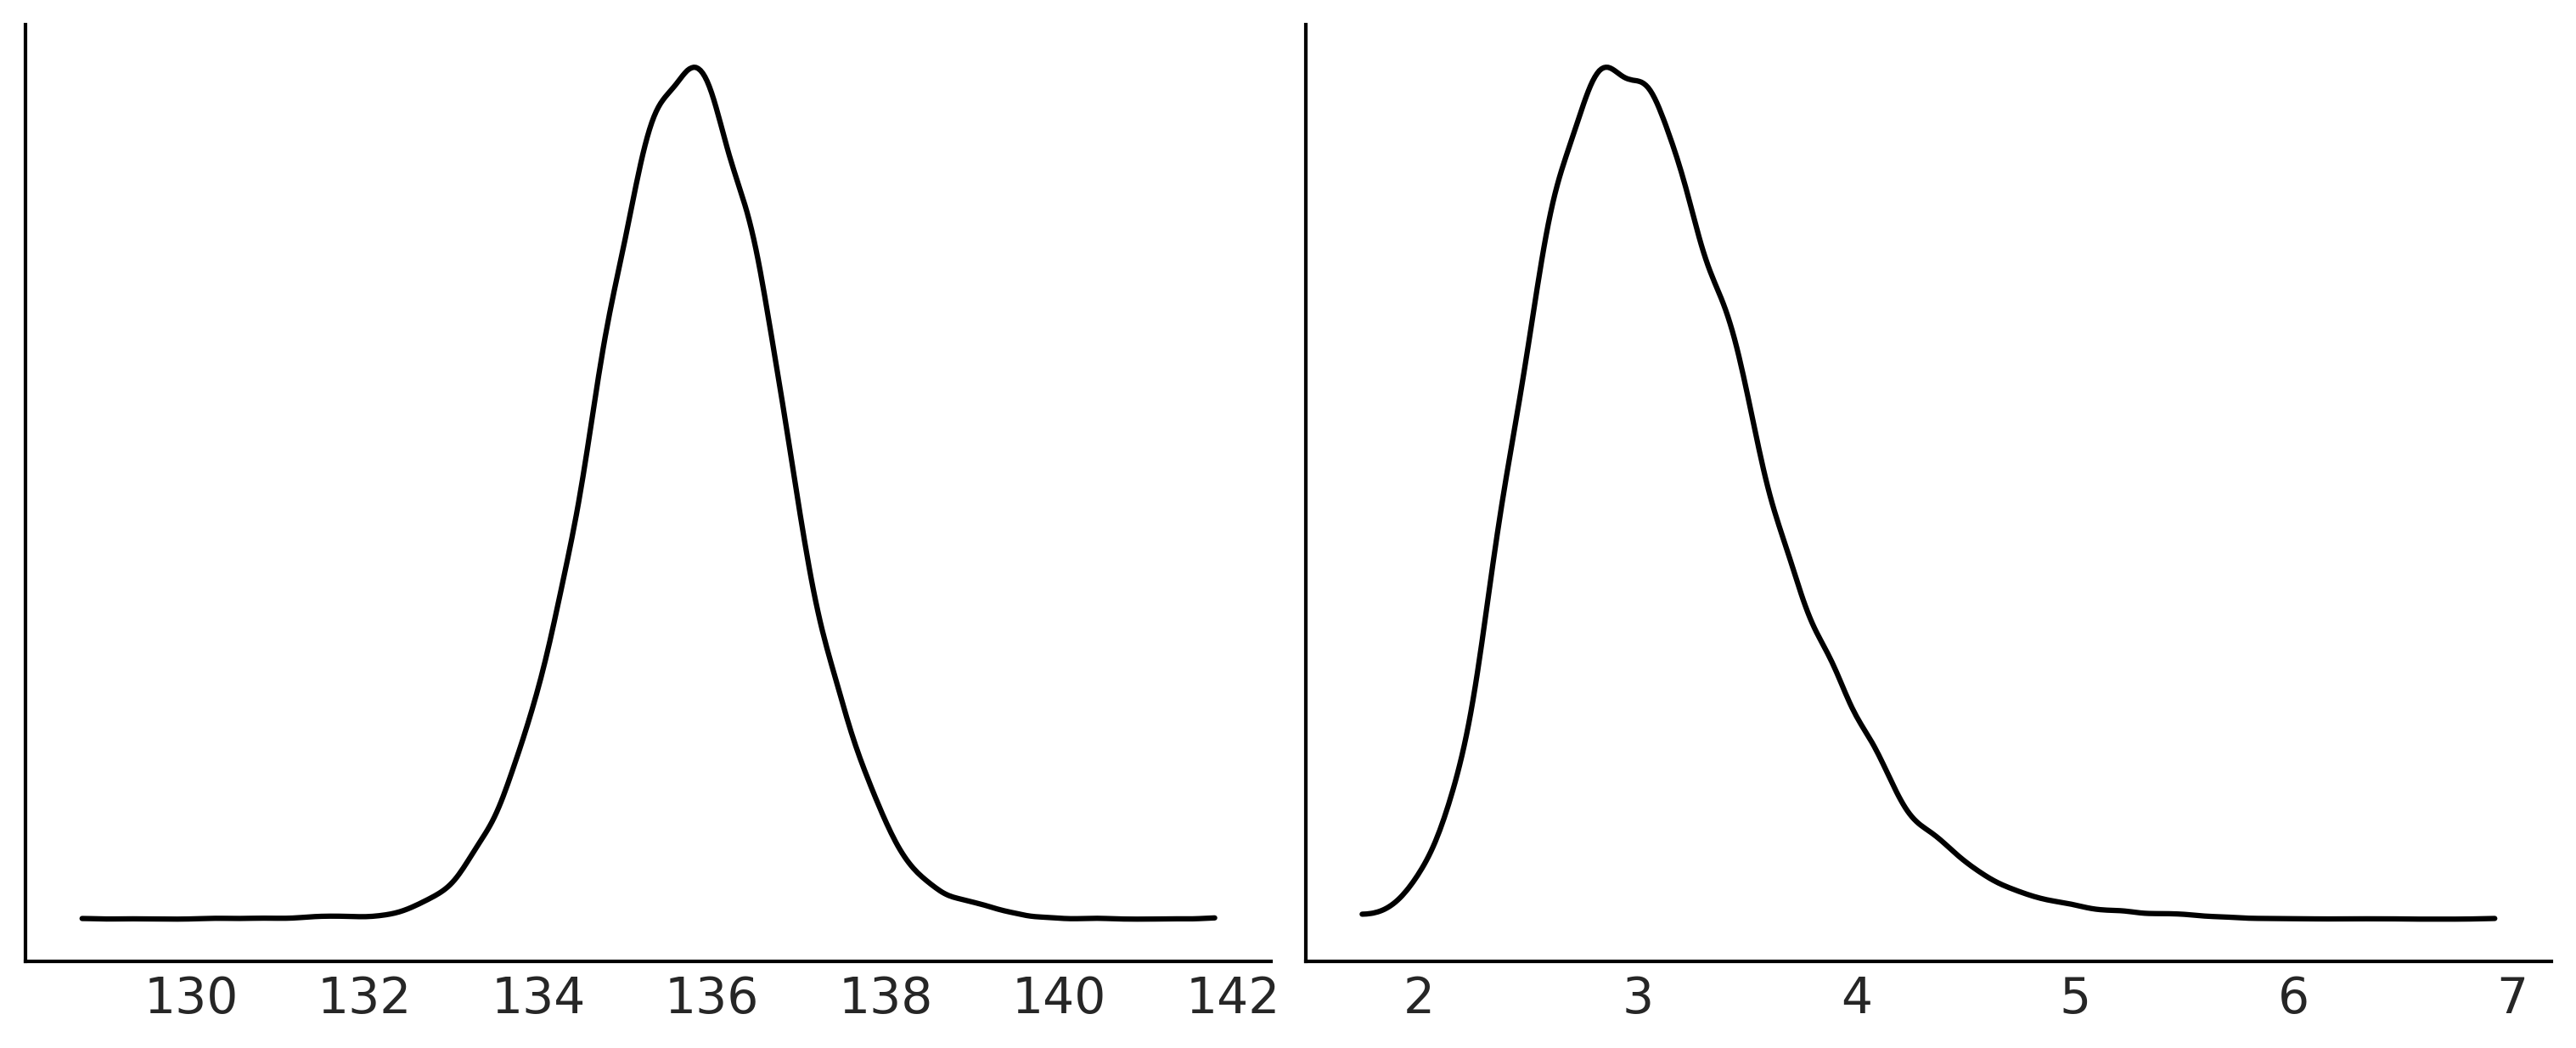

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
az.plot_kde(uni_data.posterior["mu_uni"], ax=axes[0]);
az.plot_kde(uni_data.posterior["sd_uni"], ax=axes[1]);
axes[0].set_yticks([])
axes[1].set_yticks([])
fig.savefig("img/chp09/kde_uni.png")

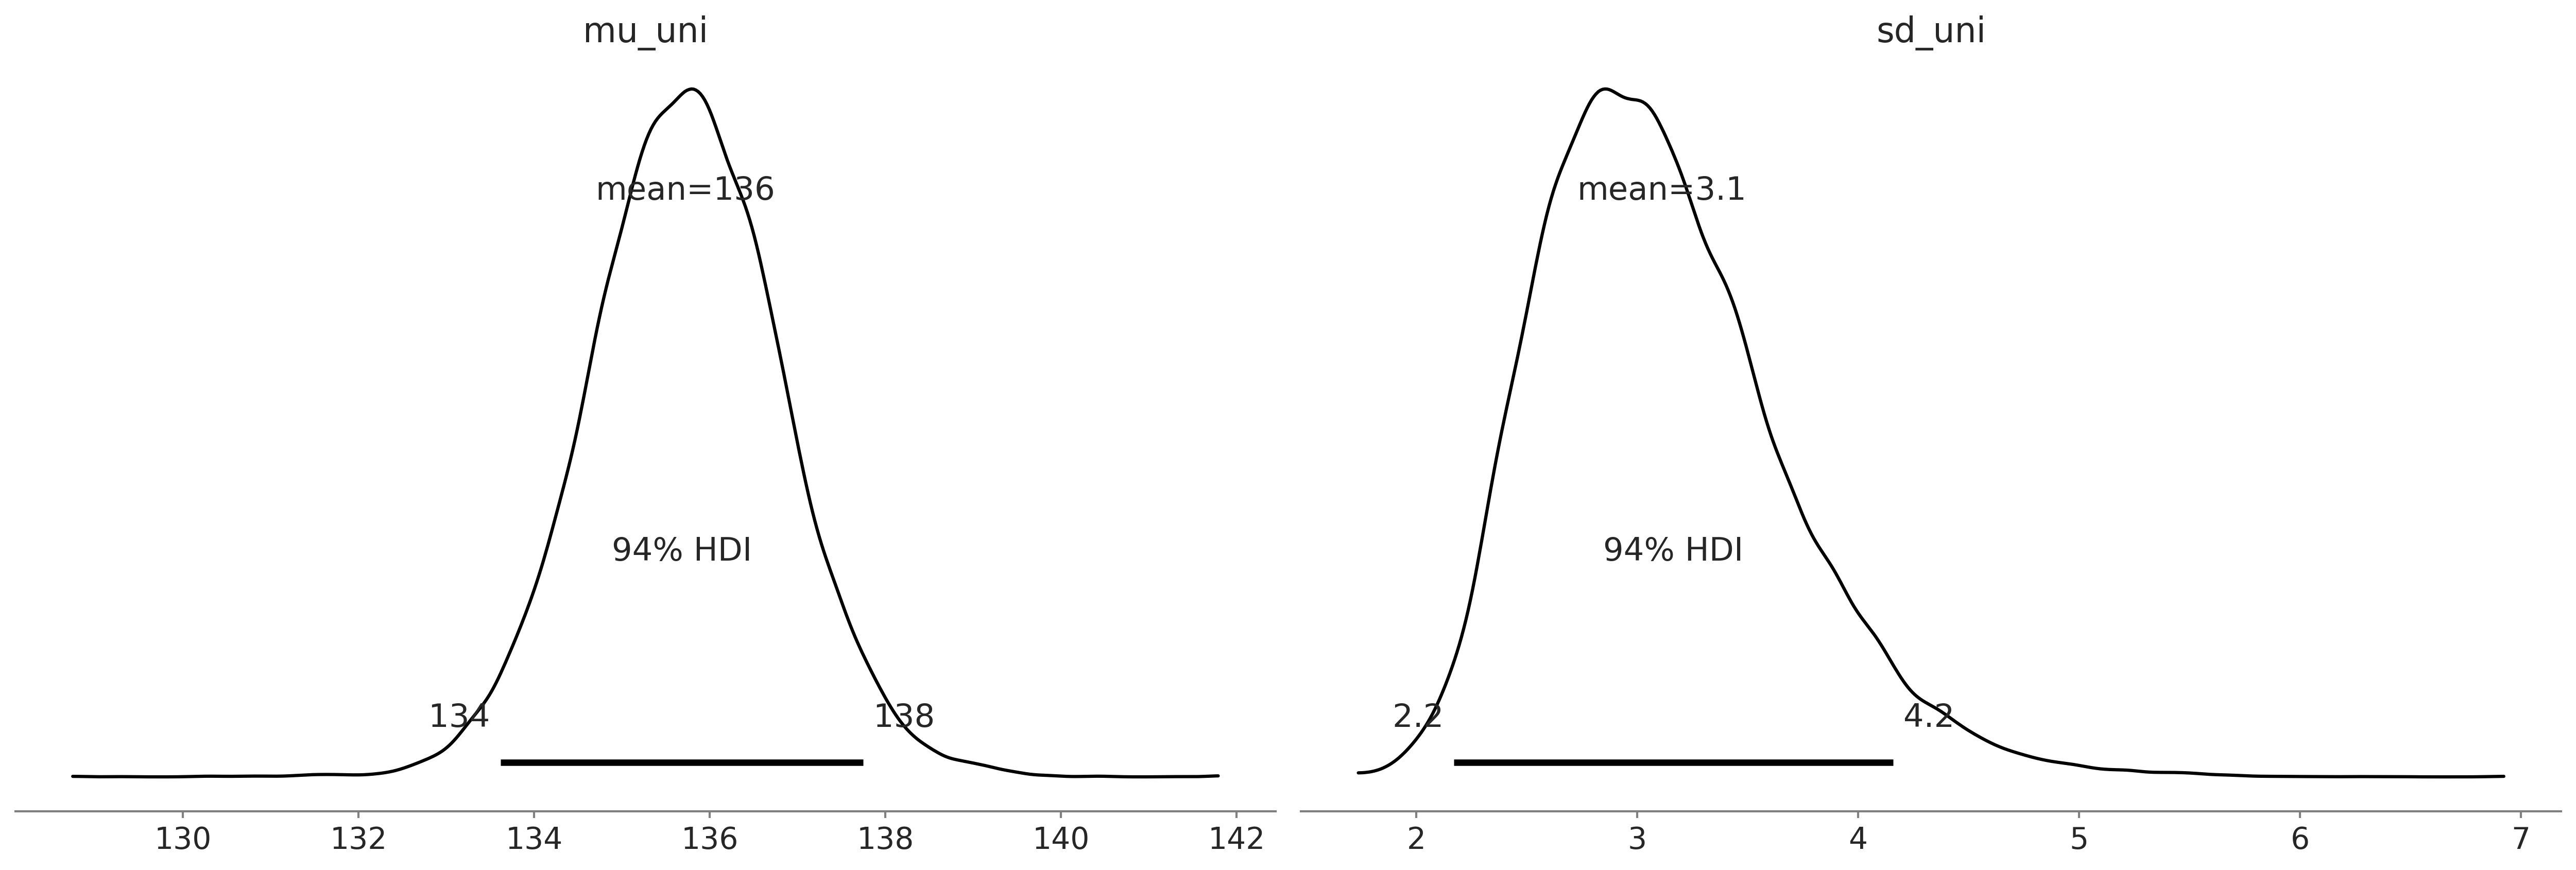

In [40]:
az.plot_posterior(uni_data);
plt.savefig("img/chp09/posterior_uni.png")

In [41]:
μ_m = 120
μ_s = 30

σ_low = 10
σ_high = 30

with pm.Model() as model:
    uni_mean = pm.Normal('uni_mean', mu=μ_m, sd=μ_s)
    bi_mean = pm.Normal('bi_mean', mu=μ_m, sd=μ_s)
    
    uni_std = pm.Uniform('uni_std', lower=σ_low, upper=σ_high)
    bi_std = pm.Uniform('bi_std', lower=σ_low, upper=σ_high)
    
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1
    
    λ1 = uni_std**-2
    λ2 = bi_std**-2

    group1 = pm.StudentT('uni', nu=ν, mu=uni_mean, lam=λ1, observed=unidirectional)
    group2 = pm.StudentT('bi', nu=ν, mu=bi_mean, lam=λ2, observed=bidirectional)
    
    diff_of_means = pm.Deterministic('Difference of Means', uni_mean - bi_mean)
    diff_of_stds = pm.Deterministic('Difference of Stds', uni_std - bi_std)
    effect_size = pm.Deterministic('Effect Size',
                                   diff_of_means / np.sqrt((uni_std**2 + bi_std**2) / 2))
    
    trace = pm.sample(draws=10000)

compare_data = az.from_pymc3(trace)

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_36222/3744684942.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, bi_std, uni_std, bi_mean, uni_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 29 seconds.
/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


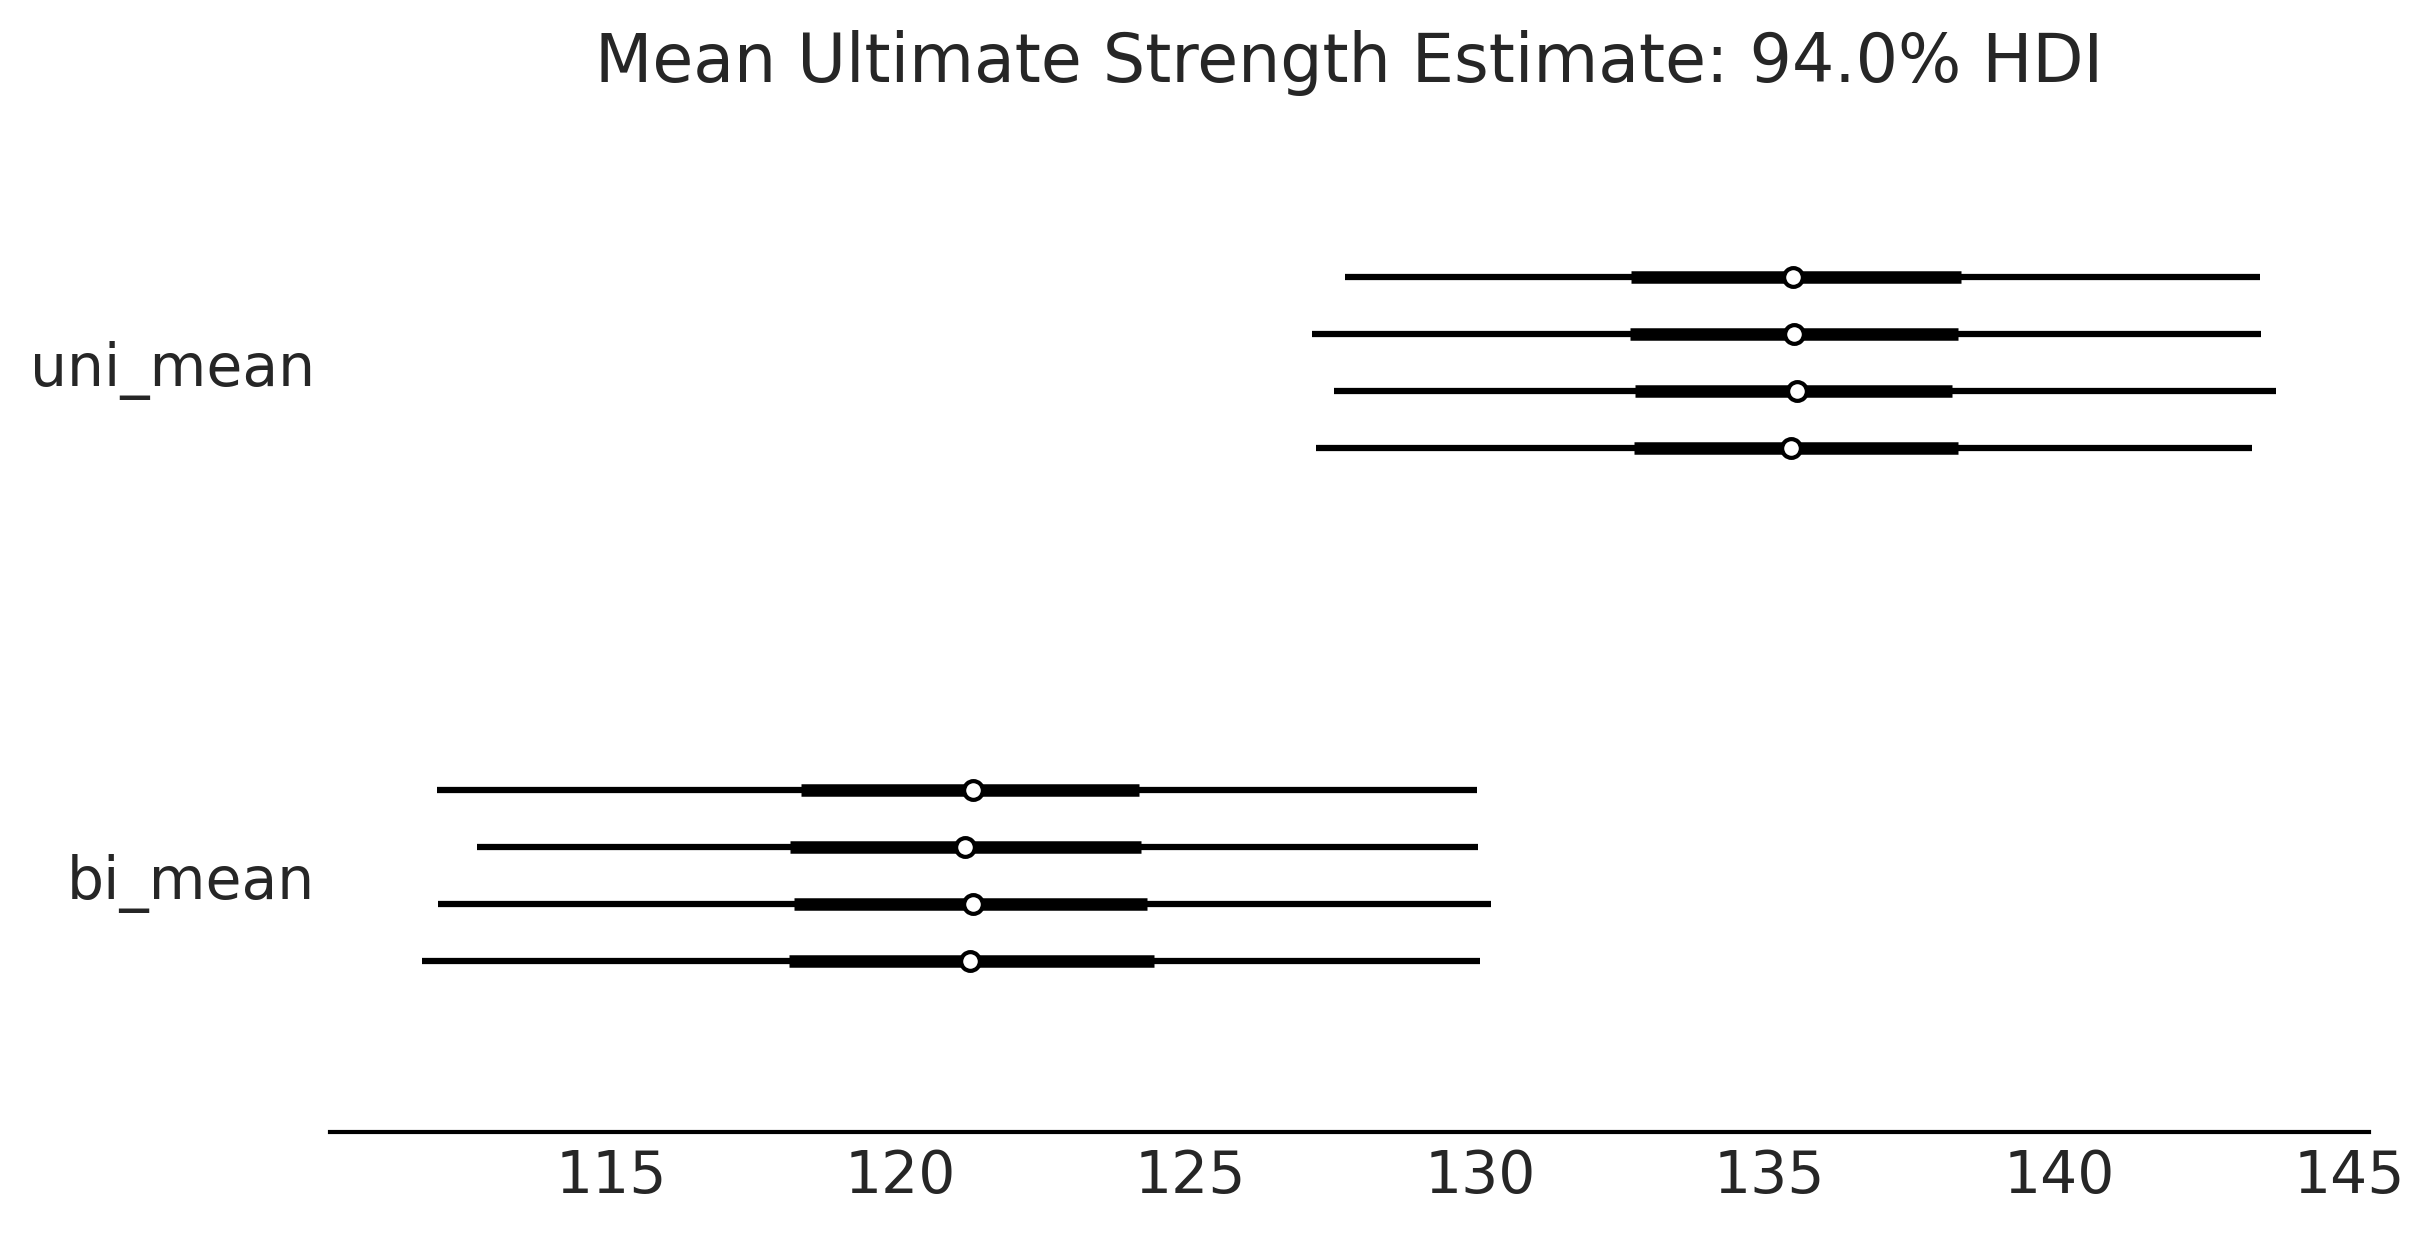

In [42]:
axes = az.plot_forest(trace, var_names=['uni_mean','bi_mean'], figsize=(8, 4));
axes[0].set_title("Mean Ultimate Strength Estimate: 94.0% HDI")
plt.savefig("img/chp09/Posterior_Forest_Plot.png")

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


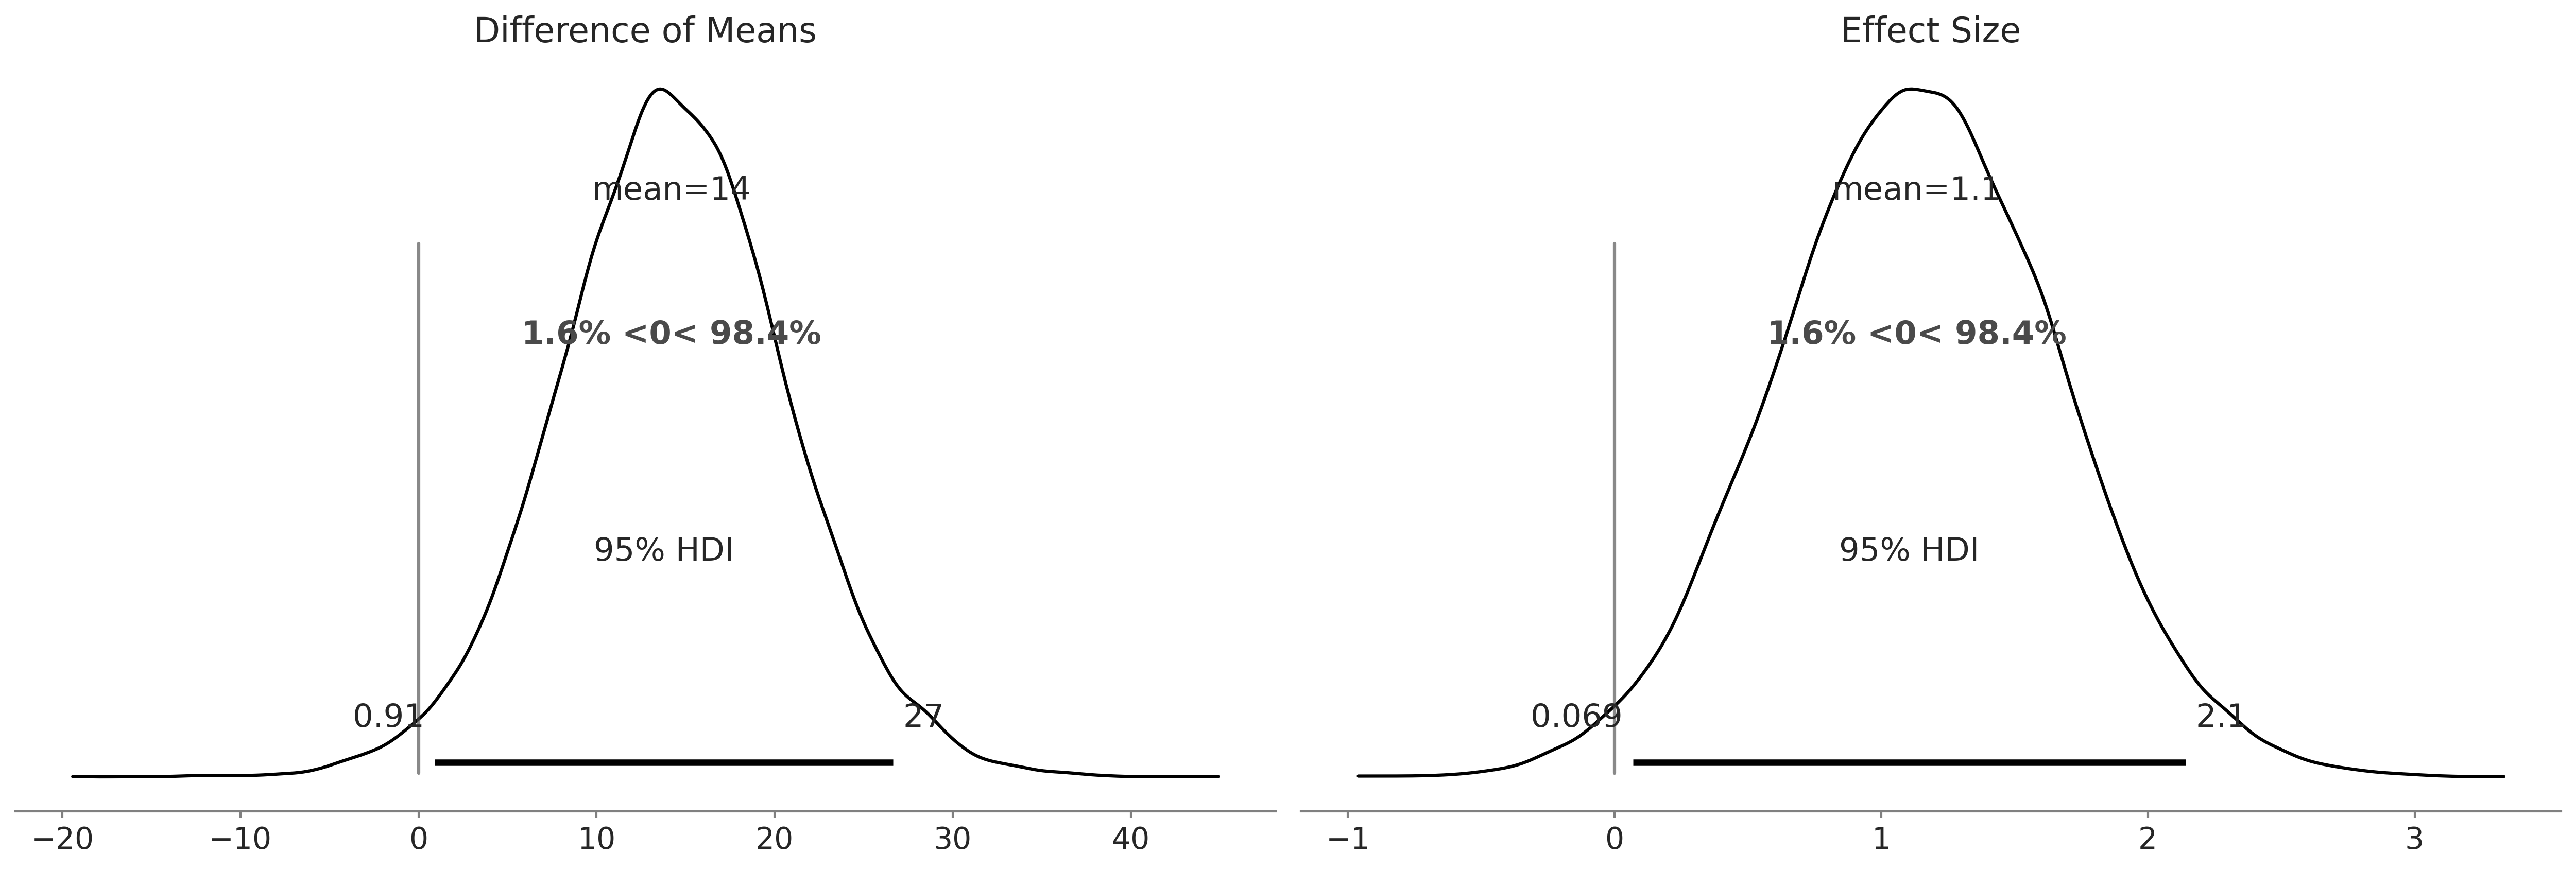

In [44]:
az.plot_posterior(trace, var_names=['Difference of Means','Effect Size'], hdi_prob=.95, ref_val=0);
plt.savefig("img/chp09/composite_difference_of_means.png")